In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import catboost as cb
print("cb.__version__:", cb.__version__)

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

cb.__version__: 1.2.7


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

Id GameRulesetName                                        agent1  \
0            0             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
1            1             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
2            2             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
3            3             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
4            4             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
...        ...             ...                                           ...   
233229  233229     Zuz_Mel_7x7        MCTS-UCB1Tuned-1.41421356237-NST-false   
233230  233230     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233231  233231     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233232  233232     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233233  233233     Zuz_Mel_7x7   MCTS-UCB1Tuned-1.41421356237-Random200-true   

                                                   agent2  Properties  Format  \
0             MCTS-ProgressiveHistory-0.6-Random200-false           1       1   
1                             MCTS-UCB1GRAVE-0.6-NST-true           1       1   
2                                 MCTS-UCB1-0.1-NST-false           1       1   
3                                 MCTS-UCB1-0.6-NST-false           1       1   
4                  MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
...                                                   ...         ...     ...   
233229  MCTS-ProgressiveHistory-1.41421356237-Random20...           1       1   
233230                           MCTS-UCB1-0.6-MAST-false           1       1   
233231             MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
233232              MCTS-UCB1GRAVE-1.41421356237-NST-true           1       1   
233233                      MCTS-UCB1Tuned-0.6-MAST-false           1       1   

        Time  Discrete  Realtime  Turns  ...  DoLudeme  Trigger  \
0          1         1         0      1  ...         0        1   
1          1         1         0      1  ...         0        1   
2          1         1         0      1  ...         0        1   
3          1         1         0      1  ...         0        1   
4          1         1         0      1  ...         0        1   
...      ...       ...       ...    ...  ...       ...      ...   
233229     1         1         0      1  ...         0        0   
233230     1         1         0      1  ...         0        0   
233231     1         1         0      1  ...         0        0   
233232     1         1         0      1  ...         0        0   
233233     1         1         0      1  ...         0        0   

        PlayoutsPerSecond  MovesPerSecond  \
0                  298.07        18877.17   
1                  298.07        18877.17   
2                  298.07        18877.17   
3                  298.07        18877.17   
4                  298.07        18877.17   
...                   ...             ...   
233229             157.52       157174.58   
233230             157.52       157174.58   
233231             157.52       157174.58   
233232             157.52       157174.58   
233233             157.52       157174.58   

                                             EnglishRules  \
0       Goal: Connect all three edge colors with a sin...   
1       Goal: Connect all three edge colors with a sin...   
2       Goal: Connect all three edge colors with a sin...   
3       Goal: Connect all three edge colors with a sin...   
4       Goal: Connect all three edge colors with a sin...   
...                                                   ...   
233229  7x7 board. 24 pieces per player. Pieces begin ...   
233230  7x7 board. 24 pieces per player. Pieces begin ...   
233231  7x7 board. 24 pieces per player. Pieces begin ...   
233232  7x7 board. 24 pieces per player. Pieces begin ...   
233233  7x7 board. 24 pieces per player. Pieces begin ...   


In [3]:
# Load the feature selection results
fs_type = 'uni90'

In [4]:
# Parameters
fs_type = "int99"


In [5]:
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

text_cols = ["LudRules",]
# text_cols = None

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 288
Categorical features: 8
Text features: 1


In [6]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=False if fs_type=="full" else True,
    include_text_features=True,
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0


number of constant cols:  0


Numerical Columns: 362
Categorical Columns: 8


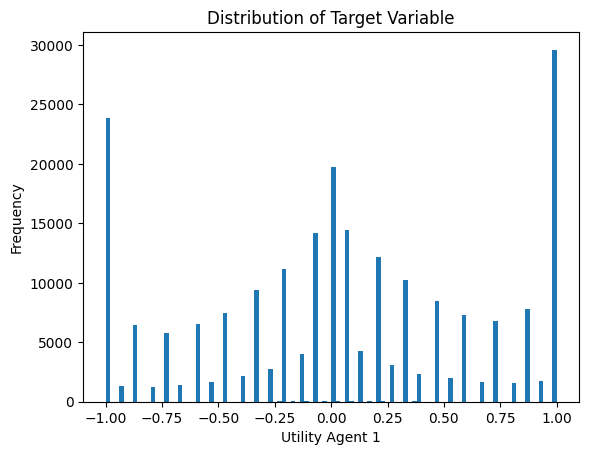

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [8]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model

In [9]:
def get_feature_importance(model, importance_type='PredictionValuesChange'):
    """
    Get feature importance from a trained CatBoost model
    
    Args:
        model: Trained CatBoost model
        importance_type: Type of feature importance to calculate
            Options: 'PredictionValuesChange', 'LossFunctionChange', 
            'ShapValues', 'Interaction', 'TopKitty'
        
    Returns:
        pandas.DataFrame: DataFrame containing feature names and their importance scores
    """
    # Get feature importance scores
    importance_scores = model.get_feature_importance(type=importance_type)
    feature_names = model.feature_names_
    
    # Create dataframe with feature names and importance scores
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance_scores
    }).sort_values('importance', ascending=False, ignore_index=True)
    
    return importance_df


def plot_feature_importance(importance_df, top_n=100):
    plot_df = importance_df.head(top_n)
    
    plt.figure(figsize=(15, 5))
    plt.bar(x=range(len(plot_df)), height=plot_df['importance'])
    plt.xticks(range(len(plot_df)), plot_df['feature'], rotation=45, ha='right', fontsize=8)
    plt.ylabel('Importance Score')
    plt.title(f'Top {top_n} Most Important Features')
    plt.tight_layout()
    plt.show()

In [10]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        text_cols=None,
        target='utility_agent1',
        split_list=None,
    ):
    # Define the parameters for CatBoost
    params = {

        'objective': "RMSE",
        'learning_rate': 0.1,
        'depth': 10,
        'iterations': 3000,
        'eval_metric': 'RMSE',
        'verbose': 0,
        'random_seed': 2112,
        'l2_leaf_reg': 1.,
        'random_strength': 0.2,
        'min_data_in_leaf': 50,
        'rsm': 0.8,
        'bagging_temperature' : 0.50,

        # 'text_processing': {
        #     'tokenizers': [{
        #         'tokenizer_id': 'Space',  # or 'GPT', 'Bert', etc.
        #         'separator_type': 'Space'
        #     }],
        #     'dictionaries': [{
        #         'dictionary_id': 'BiGram',
        #         'max_dictionary_size': '50000',
        #         'occurrence_lower_bound': '3',
        #         'gram_order': '2'
        #     }],
        #     'feature_calcers': [{
        #         'calcer_type': 'BoW',  # or 'NaiveBayes', 'BM25'
        #         'dictionary_id': 'BiGram'
        #     }]
        # }


        # # Text processing parameters to mimic TF-IDF
        # 'tokenizers': [{
        #     'tokenizer_id': 'Space',
        #     'separator_type': 'ByDelimiter',
        #     'delimiter': ' '
        # }],
        # 'dictionaries': [{
        #     'dictionary_id': 'NgramDict',
        #     'max_dictionary_size': '500',  # Match max_features=500
        #     'occurrence_lower_bound': '3',
        #     'gram_order': '3',  # Maximum n-gram size
        #     'min_gram_order': '2'  # Minimum n-gram size
        # }],
        # 'feature_calcers': [{
        #     'calcer_type': 'BoW',  # Most similar to TF-IDF
        #     'dictionary_id': 'NgramDict'
        # }],


        # 'tokenizers': [{
        #     'tokenizer_id': 'Space',
        #     'delimiter': ' ',
        #     'separator_type': 'ByDelimiter'
        # }],
        # 'dictionaries': [{
        #     'dictionary_id': 'Word',
        #     'max_dictionary_size': '50000',
        #     'occurrence_lower_bound': '3'
        # }],
        # 'feature_calcers': [{
        #     'calcer_type': 'BoW',
        #     'dictionary_id': 'Word',
        # }]
    }
    # Obtained with optuna
    # params = {
    #     'objective': 'RMSE',
    #     'verbose': False,
    #     'random_seed': 2112,
    #     'learning_rate': 0.1,
    #     'iterations': 3000,
    #     'bootstrap_type': 'Bayesian',
    #     'sampling_frequency': 'PerTreeLevel',
    #     'depth': 10,
    #     'l2_leaf_reg': 0.9359292512255313,
    #     'random_strength': 0.16693257025108216,
    #     'bagging_temperature': 0.15967219011745193,
    #     'rsm': 0.548125395769786,
    #     'min_data_in_leaf': 102,
    #     'max_ctr_complexity': 10
    # }


    # below are default params for text processing
    # 'text_processing': {
    #     'tokenizers': [{
    #         'tokenizer_id': 'Space',  # Simple space-based tokenization
    #         'separator_type': 'Space'
    #     }],
    #     'dictionaries': [{
    #         'dictionary_id': 'UniGram',  # Single words/tokens
    #         'max_dictionary_size': '50000',  # Maximum number of unique tokens to keep
    #         'occurrence_lower_bound': '3'  # Minimum number of times a token must appear
    #     }],
    #     'feature_calcers': [{
    #         'calcer_type': 'BoW',  # Bag of Words representation
    #         'dictionary_id': 'UniGram'
    #     }]
    # }


    # if text_cols:
    #     params.update({
    #         'text_processing': {
    #             'tokenizers': [{
    #                 'tokenizer_id': 'Space',  # or 'GPT', 'Bert', etc.
    #                 'separator_type': 'Space'
    #             }],
    #             'dictionaries': [{
    #                 'dictionary_id': 'BiGram',
    #                 'max_dictionary_size': '50000',
    #                 'occurrence_lower_bound': '3',
    #                 'gram_order': '2'
    #             }],
    #             'feature_calcers': [{
    #                 'calcer_type': 'BoW',  # or 'NaiveBayes', 'BM25'
    #                 'dictionary_id': 'BiGram'
    #             }]
    #         }
    #     })

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_valid = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_valid = X_train[target], X_valid[target]

        # Prepare feature list
        feature_cols = numerical_cols + categorical_cols
        if text_cols:
            feature_cols += text_cols

        # Initialize CatBoost Pool
        train_pool = cb.Pool(
            data=X_train[feature_cols],
            label=y_train,
            cat_features=categorical_cols,
            text_features=text_cols if text_cols else None
        )
        val_pool = cb.Pool(
            data=X_valid[feature_cols],
            label=y_valid,
            cat_features=categorical_cols,
            text_features=text_cols if text_cols else None
        )
        
        # Initialize CatBoost Regressor
        model = cb.CatBoostRegressor(**params)
        
        # Train the model
        model.fit(
            train_pool,
            eval_set=val_pool,
            use_best_model=True,
            verbose=50
        )

        feat_importance = get_feature_importance(model)
        feat_importance = feat_importance.rename(columns={'importance': f'importance_f{fold}'})
        feat_importance_dfs.append(feat_importance)
        plot_feature_importance(feat_importance.rename(columns={f'importance_f{fold}': 'importance'}))
        
        # Save the trained model to the list
        trained_models.append(model)

        # Predict on validation set
        y_pred = model.predict(val_pool)

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_valid
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold
        
        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_valid) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    return trained_models, oof, oof_scores, importance_df

Fold 1


0:	learn: 0.6110794	test: 0.5498890	best: 0.5498890 (0)	total: 679ms	remaining: 33m 56s


50:	learn: 0.3910623	test: 0.4695637	best: 0.4695637 (50)	total: 32s	remaining: 30m 53s


100:	learn: 0.3535387	test: 0.4504945	best: 0.4504945 (100)	total: 1m 3s	remaining: 30m 17s


150:	learn: 0.3292111	test: 0.4408550	best: 0.4408550 (150)	total: 1m 34s	remaining: 29m 49s


200:	learn: 0.3116456	test: 0.4349154	best: 0.4349154 (200)	total: 2m 5s	remaining: 29m 11s


250:	learn: 0.2992795	test: 0.4320543	best: 0.4320543 (250)	total: 2m 37s	remaining: 28m 41s


300:	learn: 0.2887020	test: 0.4303662	best: 0.4302939 (299)	total: 3m 8s	remaining: 28m 12s


350:	learn: 0.2806903	test: 0.4288464	best: 0.4288308 (349)	total: 3m 40s	remaining: 27m 41s


400:	learn: 0.2738657	test: 0.4276992	best: 0.4276901 (394)	total: 4m 11s	remaining: 27m 11s


450:	learn: 0.2674357	test: 0.4264683	best: 0.4264683 (450)	total: 4m 44s	remaining: 26m 46s


500:	learn: 0.2621753	test: 0.4257133	best: 0.4257133 (500)	total: 5m 16s	remaining: 26m 17s


550:	learn: 0.2568931	test: 0.4250033	best: 0.4249775 (549)	total: 5m 48s	remaining: 25m 48s


600:	learn: 0.2526580	test: 0.4247565	best: 0.4247565 (600)	total: 6m 20s	remaining: 25m 19s


650:	learn: 0.2485562	test: 0.4247119	best: 0.4245965 (638)	total: 6m 53s	remaining: 24m 51s


700:	learn: 0.2449042	test: 0.4241834	best: 0.4241590 (693)	total: 7m 26s	remaining: 24m 24s


750:	learn: 0.2415393	test: 0.4239253	best: 0.4239253 (750)	total: 7m 59s	remaining: 23m 57s


800:	learn: 0.2386368	test: 0.4238074	best: 0.4237657 (789)	total: 8m 32s	remaining: 23m 27s


850:	learn: 0.2356339	test: 0.4235167	best: 0.4234997 (844)	total: 9m 4s	remaining: 22m 55s


900:	learn: 0.2329556	test: 0.4231703	best: 0.4231703 (900)	total: 9m 37s	remaining: 22m 26s


950:	learn: 0.2303026	test: 0.4228986	best: 0.4228986 (950)	total: 10m 10s	remaining: 21m 54s


1000:	learn: 0.2277212	test: 0.4228647	best: 0.4228590 (998)	total: 10m 42s	remaining: 21m 22s


1050:	learn: 0.2253774	test: 0.4227223	best: 0.4227207 (1049)	total: 11m 14s	remaining: 20m 51s


1100:	learn: 0.2229262	test: 0.4225391	best: 0.4225391 (1100)	total: 11m 47s	remaining: 20m 19s


1150:	learn: 0.2208154	test: 0.4223485	best: 0.4223485 (1150)	total: 12m 19s	remaining: 19m 47s


1200:	learn: 0.2188124	test: 0.4221328	best: 0.4220956 (1190)	total: 12m 52s	remaining: 19m 16s


1250:	learn: 0.2168634	test: 0.4220289	best: 0.4220248 (1246)	total: 13m 24s	remaining: 18m 44s


1300:	learn: 0.2150934	test: 0.4219251	best: 0.4218740 (1281)	total: 13m 56s	remaining: 18m 12s


1350:	learn: 0.2131752	test: 0.4219400	best: 0.4218740 (1281)	total: 14m 28s	remaining: 17m 40s


1400:	learn: 0.2115858	test: 0.4218922	best: 0.4218740 (1281)	total: 15m 1s	remaining: 17m 8s


1450:	learn: 0.2098992	test: 0.4218253	best: 0.4218253 (1450)	total: 15m 33s	remaining: 16m 36s


1500:	learn: 0.2081929	test: 0.4217228	best: 0.4217220 (1489)	total: 16m 5s	remaining: 16m 4s


1550:	learn: 0.2065489	test: 0.4216537	best: 0.4216505 (1522)	total: 16m 38s	remaining: 15m 32s


1600:	learn: 0.2050431	test: 0.4216805	best: 0.4216118 (1577)	total: 17m 10s	remaining: 15m


1650:	learn: 0.2035348	test: 0.4216092	best: 0.4216015 (1648)	total: 17m 43s	remaining: 14m 28s


1700:	learn: 0.2020047	test: 0.4216539	best: 0.4215910 (1660)	total: 18m 15s	remaining: 13m 56s


1750:	learn: 0.2004824	test: 0.4217587	best: 0.4215910 (1660)	total: 18m 48s	remaining: 13m 24s


1800:	learn: 0.1990675	test: 0.4217254	best: 0.4215910 (1660)	total: 19m 20s	remaining: 12m 52s


1850:	learn: 0.1976090	test: 0.4217512	best: 0.4215910 (1660)	total: 19m 53s	remaining: 12m 20s


1900:	learn: 0.1962913	test: 0.4217979	best: 0.4215910 (1660)	total: 20m 26s	remaining: 11m 48s


1950:	learn: 0.1948979	test: 0.4217986	best: 0.4215910 (1660)	total: 20m 58s	remaining: 11m 16s


2000:	learn: 0.1935903	test: 0.4217691	best: 0.4215910 (1660)	total: 21m 31s	remaining: 10m 44s


2050:	learn: 0.1922431	test: 0.4217145	best: 0.4215910 (1660)	total: 22m 4s	remaining: 10m 12s


2100:	learn: 0.1909650	test: 0.4217011	best: 0.4215910 (1660)	total: 22m 36s	remaining: 9m 40s


2150:	learn: 0.1895637	test: 0.4213908	best: 0.4213905 (2149)	total: 23m 8s	remaining: 9m 8s


2200:	learn: 0.1884284	test: 0.4214474	best: 0.4213905 (2149)	total: 23m 41s	remaining: 8m 36s


2250:	learn: 0.1872896	test: 0.4214446	best: 0.4213905 (2149)	total: 24m 14s	remaining: 8m 3s


2300:	learn: 0.1859160	test: 0.4215094	best: 0.4213905 (2149)	total: 24m 46s	remaining: 7m 31s


2350:	learn: 0.1846869	test: 0.4213698	best: 0.4213698 (2350)	total: 25m 18s	remaining: 6m 59s


2400:	learn: 0.1835156	test: 0.4213986	best: 0.4213487 (2367)	total: 25m 51s	remaining: 6m 27s


2450:	learn: 0.1824491	test: 0.4213944	best: 0.4213487 (2367)	total: 26m 24s	remaining: 5m 54s


2500:	learn: 0.1812874	test: 0.4213365	best: 0.4213365 (2500)	total: 26m 57s	remaining: 5m 22s


2550:	learn: 0.1801033	test: 0.4213465	best: 0.4213116 (2515)	total: 27m 29s	remaining: 4m 50s


2600:	learn: 0.1788841	test: 0.4212958	best: 0.4212878 (2580)	total: 28m 1s	remaining: 4m 17s


2650:	learn: 0.1778509	test: 0.4213197	best: 0.4212878 (2580)	total: 28m 34s	remaining: 3m 45s


2700:	learn: 0.1766963	test: 0.4212766	best: 0.4212724 (2685)	total: 29m 7s	remaining: 3m 13s


2750:	learn: 0.1756809	test: 0.4212202	best: 0.4212202 (2750)	total: 29m 40s	remaining: 2m 41s


2800:	learn: 0.1746877	test: 0.4211746	best: 0.4211652 (2780)	total: 30m 12s	remaining: 2m 8s


2850:	learn: 0.1736186	test: 0.4211183	best: 0.4210944 (2834)	total: 30m 45s	remaining: 1m 36s


2900:	learn: 0.1726375	test: 0.4211144	best: 0.4210918 (2868)	total: 31m 18s	remaining: 1m 4s


2950:	learn: 0.1716456	test: 0.4211042	best: 0.4210838 (2935)	total: 31m 50s	remaining: 31.7s


2999:	learn: 0.1706246	test: 0.4210682	best: 0.4210667 (2971)	total: 32m 22s	remaining: 0us

bestTest = 0.4210666502
bestIteration = 2971

Shrink model to first 2972 iterations.


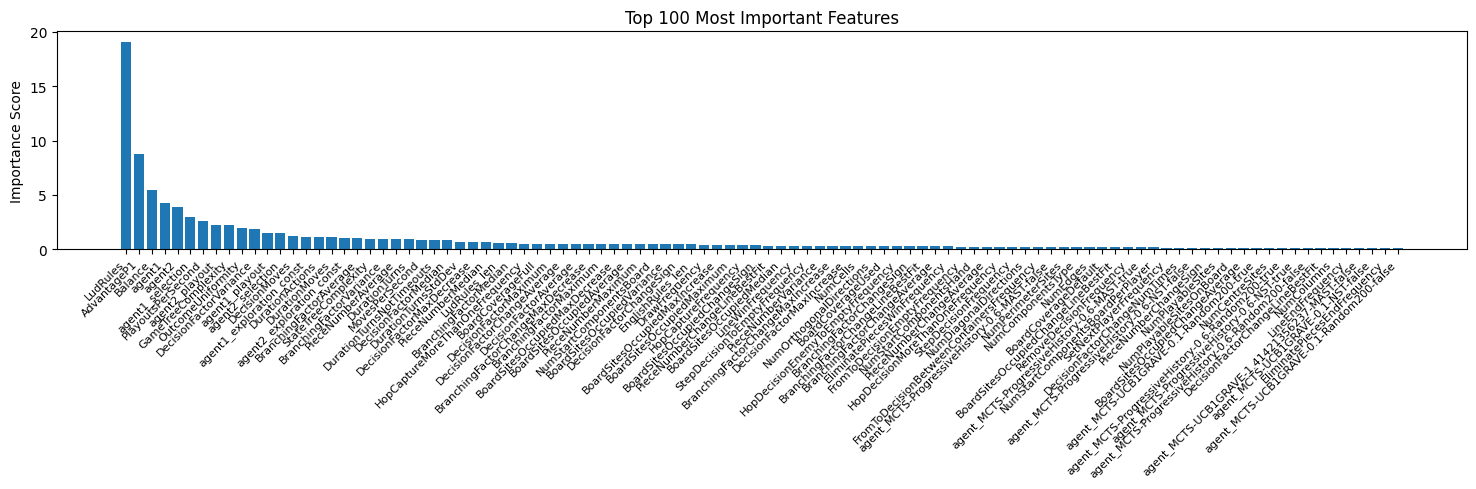

Fold 1 - RMSE: 0.42058730048649756
Fold 2


0:	learn: 0.6043385	test: 0.5811363	best: 0.5811363 (0)	total: 672ms	remaining: 33m 33s


50:	learn: 0.3974512	test: 0.4711147	best: 0.4711147 (50)	total: 34.2s	remaining: 32m 55s


100:	learn: 0.3599900	test: 0.4541728	best: 0.4541728 (100)	total: 1m 8s	remaining: 32m 36s


150:	learn: 0.3382705	test: 0.4460213	best: 0.4460213 (150)	total: 1m 41s	remaining: 32m 3s


200:	learn: 0.3230285	test: 0.4430540	best: 0.4429446 (197)	total: 2m 15s	remaining: 31m 29s


250:	learn: 0.3124971	test: 0.4414554	best: 0.4414206 (239)	total: 2m 49s	remaining: 30m 53s


300:	learn: 0.3026903	test: 0.4389918	best: 0.4389918 (300)	total: 3m 22s	remaining: 30m 18s


350:	learn: 0.2945523	test: 0.4379149	best: 0.4379149 (350)	total: 3m 56s	remaining: 29m 46s


400:	learn: 0.2864949	test: 0.4370252	best: 0.4370252 (400)	total: 4m 30s	remaining: 29m 10s


450:	learn: 0.2800700	test: 0.4356291	best: 0.4356291 (450)	total: 5m 4s	remaining: 28m 38s


500:	learn: 0.2745353	test: 0.4347246	best: 0.4347215 (499)	total: 5m 37s	remaining: 28m 5s


550:	learn: 0.2696132	test: 0.4340023	best: 0.4339929 (549)	total: 6m 11s	remaining: 27m 31s


600:	learn: 0.2651039	test: 0.4335064	best: 0.4334839 (599)	total: 6m 45s	remaining: 26m 59s


650:	learn: 0.2608067	test: 0.4328089	best: 0.4328089 (650)	total: 7m 20s	remaining: 26m 28s


700:	learn: 0.2570341	test: 0.4324784	best: 0.4324163 (685)	total: 7m 54s	remaining: 25m 55s


750:	learn: 0.2536474	test: 0.4320702	best: 0.4320702 (750)	total: 8m 29s	remaining: 25m 24s


800:	learn: 0.2502515	test: 0.4318303	best: 0.4317910 (793)	total: 9m 3s	remaining: 24m 51s


850:	learn: 0.2471168	test: 0.4312551	best: 0.4312551 (850)	total: 9m 38s	remaining: 24m 20s


900:	learn: 0.2443499	test: 0.4311403	best: 0.4311397 (899)	total: 10m 12s	remaining: 23m 46s


950:	learn: 0.2415560	test: 0.4308905	best: 0.4308905 (950)	total: 10m 46s	remaining: 23m 13s


1000:	learn: 0.2390728	test: 0.4307519	best: 0.4307326 (981)	total: 11m 21s	remaining: 22m 40s


1050:	learn: 0.2365710	test: 0.4306534	best: 0.4306338 (1038)	total: 11m 55s	remaining: 22m 7s


1100:	learn: 0.2345550	test: 0.4308351	best: 0.4306338 (1038)	total: 12m 30s	remaining: 21m 34s


1150:	learn: 0.2323760	test: 0.4307863	best: 0.4306338 (1038)	total: 13m 4s	remaining: 21m


1200:	learn: 0.2301990	test: 0.4306431	best: 0.4306338 (1038)	total: 13m 38s	remaining: 20m 26s


1250:	learn: 0.2281373	test: 0.4305079	best: 0.4305037 (1249)	total: 14m 13s	remaining: 19m 52s


1300:	learn: 0.2260160	test: 0.4304001	best: 0.4304001 (1300)	total: 14m 47s	remaining: 19m 18s


1350:	learn: 0.2242121	test: 0.4301988	best: 0.4301787 (1345)	total: 15m 21s	remaining: 18m 44s


1400:	learn: 0.2223003	test: 0.4301559	best: 0.4301511 (1399)	total: 15m 55s	remaining: 18m 10s


1450:	learn: 0.2205213	test: 0.4301511	best: 0.4301511 (1450)	total: 16m 30s	remaining: 17m 37s


1500:	learn: 0.2187729	test: 0.4301201	best: 0.4300745 (1494)	total: 17m 4s	remaining: 17m 3s


1550:	learn: 0.2171295	test: 0.4300500	best: 0.4300404 (1538)	total: 17m 39s	remaining: 16m 29s


1600:	learn: 0.2154186	test: 0.4299450	best: 0.4299133 (1590)	total: 18m 14s	remaining: 15m 55s


1650:	learn: 0.2138297	test: 0.4298903	best: 0.4298903 (1650)	total: 18m 48s	remaining: 15m 22s


1700:	learn: 0.2123615	test: 0.4297635	best: 0.4297436 (1696)	total: 19m 23s	remaining: 14m 48s


1750:	learn: 0.2108806	test: 0.4297522	best: 0.4296843 (1727)	total: 19m 57s	remaining: 14m 14s


1800:	learn: 0.2094303	test: 0.4297250	best: 0.4296843 (1727)	total: 20m 32s	remaining: 13m 40s


1850:	learn: 0.2077969	test: 0.4297077	best: 0.4296639 (1821)	total: 21m 6s	remaining: 13m 6s


1900:	learn: 0.2064834	test: 0.4296621	best: 0.4296485 (1877)	total: 21m 40s	remaining: 12m 32s


1950:	learn: 0.2052962	test: 0.4296257	best: 0.4296237 (1940)	total: 22m 15s	remaining: 11m 57s


2000:	learn: 0.2037703	test: 0.4295368	best: 0.4295351 (1998)	total: 22m 49s	remaining: 11m 23s


2050:	learn: 0.2025048	test: 0.4294468	best: 0.4294468 (2050)	total: 23m 24s	remaining: 10m 49s


2100:	learn: 0.2010625	test: 0.4292967	best: 0.4292949 (2094)	total: 23m 59s	remaining: 10m 15s


2150:	learn: 0.1997107	test: 0.4293452	best: 0.4292671 (2127)	total: 24m 33s	remaining: 9m 41s


2200:	learn: 0.1984082	test: 0.4292313	best: 0.4291876 (2192)	total: 25m 8s	remaining: 9m 7s


2250:	learn: 0.1971803	test: 0.4292476	best: 0.4291876 (2192)	total: 25m 43s	remaining: 8m 33s


2300:	learn: 0.1959583	test: 0.4292569	best: 0.4291876 (2192)	total: 26m 17s	remaining: 7m 59s


2350:	learn: 0.1948249	test: 0.4292514	best: 0.4291876 (2192)	total: 26m 52s	remaining: 7m 25s


2400:	learn: 0.1936786	test: 0.4292869	best: 0.4291876 (2192)	total: 27m 27s	remaining: 6m 51s


2450:	learn: 0.1925055	test: 0.4293069	best: 0.4291876 (2192)	total: 28m 2s	remaining: 6m 16s


2500:	learn: 0.1914516	test: 0.4292384	best: 0.4291876 (2192)	total: 28m 37s	remaining: 5m 42s


2550:	learn: 0.1903637	test: 0.4291579	best: 0.4291573 (2549)	total: 29m 11s	remaining: 5m 8s


2600:	learn: 0.1892644	test: 0.4291764	best: 0.4291436 (2565)	total: 29m 46s	remaining: 4m 34s


2650:	learn: 0.1881582	test: 0.4291063	best: 0.4291063 (2650)	total: 30m 20s	remaining: 3m 59s


2700:	learn: 0.1870381	test: 0.4291127	best: 0.4290832 (2691)	total: 30m 55s	remaining: 3m 25s


2750:	learn: 0.1860156	test: 0.4290837	best: 0.4290664 (2742)	total: 31m 29s	remaining: 2m 51s


2800:	learn: 0.1850687	test: 0.4290359	best: 0.4290261 (2787)	total: 32m 5s	remaining: 2m 16s


2850:	learn: 0.1840085	test: 0.4290338	best: 0.4290097 (2820)	total: 32m 39s	remaining: 1m 42s


2900:	learn: 0.1830273	test: 0.4290249	best: 0.4289860 (2885)	total: 33m 14s	remaining: 1m 8s


2950:	learn: 0.1820560	test: 0.4290164	best: 0.4289860 (2885)	total: 33m 49s	remaining: 33.7s


2999:	learn: 0.1810076	test: 0.4290688	best: 0.4289860 (2885)	total: 34m 23s	remaining: 0us

bestTest = 0.4289859564
bestIteration = 2885

Shrink model to first 2886 iterations.


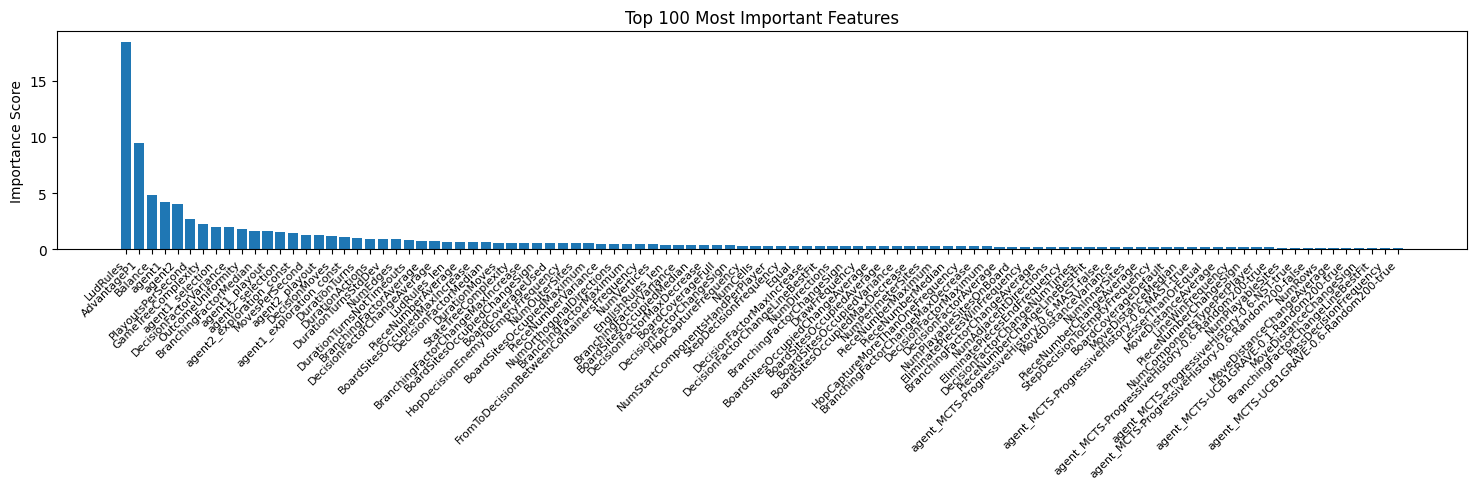

Fold 2 - RMSE: 0.42837139632717464
Fold 3


0:	learn: 0.6013205	test: 0.5946213	best: 0.5946213 (0)	total: 678ms	remaining: 33m 53s


50:	learn: 0.3958357	test: 0.4684325	best: 0.4684325 (50)	total: 34.4s	remaining: 33m 8s


100:	learn: 0.3589180	test: 0.4515336	best: 0.4515336 (100)	total: 1m 8s	remaining: 32m 48s


150:	learn: 0.3346092	test: 0.4409560	best: 0.4409560 (150)	total: 1m 42s	remaining: 32m 6s


200:	learn: 0.3177268	test: 0.4354839	best: 0.4354839 (200)	total: 2m 15s	remaining: 31m 27s


250:	learn: 0.3051711	test: 0.4331590	best: 0.4331590 (250)	total: 2m 49s	remaining: 30m 51s


300:	learn: 0.2954839	test: 0.4313931	best: 0.4313931 (300)	total: 3m 22s	remaining: 30m 17s


350:	learn: 0.2872171	test: 0.4296555	best: 0.4296555 (350)	total: 3m 56s	remaining: 29m 42s


400:	learn: 0.2803037	test: 0.4285009	best: 0.4284306 (399)	total: 4m 30s	remaining: 29m 14s


450:	learn: 0.2737979	test: 0.4275374	best: 0.4275372 (449)	total: 5m 4s	remaining: 28m 39s


500:	learn: 0.2682754	test: 0.4265622	best: 0.4265622 (500)	total: 5m 37s	remaining: 28m 4s


550:	learn: 0.2631637	test: 0.4260556	best: 0.4260556 (550)	total: 6m 11s	remaining: 27m 30s


600:	learn: 0.2586581	test: 0.4256816	best: 0.4256611 (589)	total: 6m 45s	remaining: 26m 57s


650:	learn: 0.2548091	test: 0.4252215	best: 0.4251974 (649)	total: 7m 19s	remaining: 26m 25s


700:	learn: 0.2508963	test: 0.4245539	best: 0.4245539 (700)	total: 7m 53s	remaining: 25m 53s


750:	learn: 0.2473607	test: 0.4244286	best: 0.4244195 (740)	total: 8m 27s	remaining: 25m 20s


800:	learn: 0.2440912	test: 0.4244230	best: 0.4243793 (766)	total: 9m 2s	remaining: 24m 48s


850:	learn: 0.2412337	test: 0.4240917	best: 0.4240747 (848)	total: 9m 36s	remaining: 24m 16s


900:	learn: 0.2382191	test: 0.4240046	best: 0.4239443 (894)	total: 10m 10s	remaining: 23m 42s


950:	learn: 0.2357190	test: 0.4238203	best: 0.4237945 (948)	total: 10m 44s	remaining: 23m 9s


1000:	learn: 0.2330509	test: 0.4237224	best: 0.4236929 (997)	total: 11m 18s	remaining: 22m 35s


1050:	learn: 0.2305440	test: 0.4234631	best: 0.4234631 (1050)	total: 11m 52s	remaining: 22m 2s


1100:	learn: 0.2282100	test: 0.4234288	best: 0.4234267 (1097)	total: 12m 27s	remaining: 21m 29s


1150:	learn: 0.2261773	test: 0.4234309	best: 0.4233851 (1101)	total: 13m 1s	remaining: 20m 55s


1200:	learn: 0.2240788	test: 0.4232729	best: 0.4232729 (1200)	total: 13m 35s	remaining: 20m 22s


1250:	learn: 0.2222013	test: 0.4231890	best: 0.4231552 (1244)	total: 14m 10s	remaining: 19m 48s


1300:	learn: 0.2204727	test: 0.4230210	best: 0.4230210 (1300)	total: 14m 44s	remaining: 19m 15s


1350:	learn: 0.2186180	test: 0.4228948	best: 0.4228948 (1350)	total: 15m 19s	remaining: 18m 42s


1400:	learn: 0.2169584	test: 0.4227941	best: 0.4227921 (1395)	total: 15m 53s	remaining: 18m 8s


1450:	learn: 0.2152016	test: 0.4227290	best: 0.4226972 (1427)	total: 16m 28s	remaining: 17m 34s


1500:	learn: 0.2134600	test: 0.4226500	best: 0.4226480 (1499)	total: 17m 2s	remaining: 17m 1s


1550:	learn: 0.2118997	test: 0.4225985	best: 0.4225843 (1544)	total: 17m 36s	remaining: 16m 27s


1600:	learn: 0.2102139	test: 0.4225557	best: 0.4225362 (1582)	total: 18m 10s	remaining: 15m 53s


1650:	learn: 0.2086313	test: 0.4225341	best: 0.4225053 (1642)	total: 18m 45s	remaining: 15m 19s


1700:	learn: 0.2071587	test: 0.4225202	best: 0.4224873 (1692)	total: 19m 20s	remaining: 14m 45s


1750:	learn: 0.2058019	test: 0.4224551	best: 0.4224551 (1750)	total: 19m 55s	remaining: 14m 12s


1800:	learn: 0.2044189	test: 0.4224451	best: 0.4224044 (1757)	total: 20m 29s	remaining: 13m 38s


1850:	learn: 0.2030005	test: 0.4224238	best: 0.4224044 (1757)	total: 21m 4s	remaining: 13m 4s


1900:	learn: 0.2017116	test: 0.4224034	best: 0.4223675 (1887)	total: 21m 38s	remaining: 12m 30s


1950:	learn: 0.2003150	test: 0.4223510	best: 0.4223495 (1947)	total: 22m 12s	remaining: 11m 56s


2000:	learn: 0.1989824	test: 0.4223972	best: 0.4223412 (1952)	total: 22m 46s	remaining: 11m 22s


2050:	learn: 0.1978050	test: 0.4223925	best: 0.4223412 (1952)	total: 23m 21s	remaining: 10m 48s


2100:	learn: 0.1963896	test: 0.4223313	best: 0.4223148 (2096)	total: 23m 55s	remaining: 10m 14s


2150:	learn: 0.1950988	test: 0.4223044	best: 0.4222848 (2143)	total: 24m 29s	remaining: 9m 40s


2200:	learn: 0.1938115	test: 0.4223253	best: 0.4222848 (2143)	total: 25m 4s	remaining: 9m 5s


2250:	learn: 0.1925549	test: 0.4222785	best: 0.4222769 (2249)	total: 25m 38s	remaining: 8m 31s


2300:	learn: 0.1911914	test: 0.4223355	best: 0.4222580 (2257)	total: 26m 12s	remaining: 7m 57s


2350:	learn: 0.1899146	test: 0.4222777	best: 0.4222580 (2257)	total: 26m 46s	remaining: 7m 23s


2400:	learn: 0.1887261	test: 0.4222555	best: 0.4222267 (2359)	total: 27m 21s	remaining: 6m 49s


2450:	learn: 0.1875329	test: 0.4222492	best: 0.4222267 (2359)	total: 27m 55s	remaining: 6m 15s


2500:	learn: 0.1864703	test: 0.4222846	best: 0.4222267 (2359)	total: 28m 30s	remaining: 5m 41s


2550:	learn: 0.1852999	test: 0.4222676	best: 0.4222267 (2359)	total: 29m 5s	remaining: 5m 7s


2600:	learn: 0.1842054	test: 0.4222313	best: 0.4222096 (2584)	total: 29m 39s	remaining: 4m 32s


2650:	learn: 0.1831057	test: 0.4222079	best: 0.4221819 (2643)	total: 30m 14s	remaining: 3m 58s


2700:	learn: 0.1820581	test: 0.4222168	best: 0.4221819 (2643)	total: 30m 48s	remaining: 3m 24s


2750:	learn: 0.1810519	test: 0.4222323	best: 0.4221819 (2643)	total: 31m 23s	remaining: 2m 50s


2800:	learn: 0.1799943	test: 0.4222467	best: 0.4221819 (2643)	total: 31m 57s	remaining: 2m 16s


2850:	learn: 0.1790291	test: 0.4221962	best: 0.4221819 (2643)	total: 32m 32s	remaining: 1m 42s


2900:	learn: 0.1780396	test: 0.4221695	best: 0.4221224 (2879)	total: 33m 7s	remaining: 1m 7s


2950:	learn: 0.1770429	test: 0.4221375	best: 0.4221224 (2879)	total: 33m 41s	remaining: 33.6s


2999:	learn: 0.1761050	test: 0.4221694	best: 0.4221224 (2879)	total: 34m 15s	remaining: 0us

bestTest = 0.4221224475
bestIteration = 2879

Shrink model to first 2880 iterations.


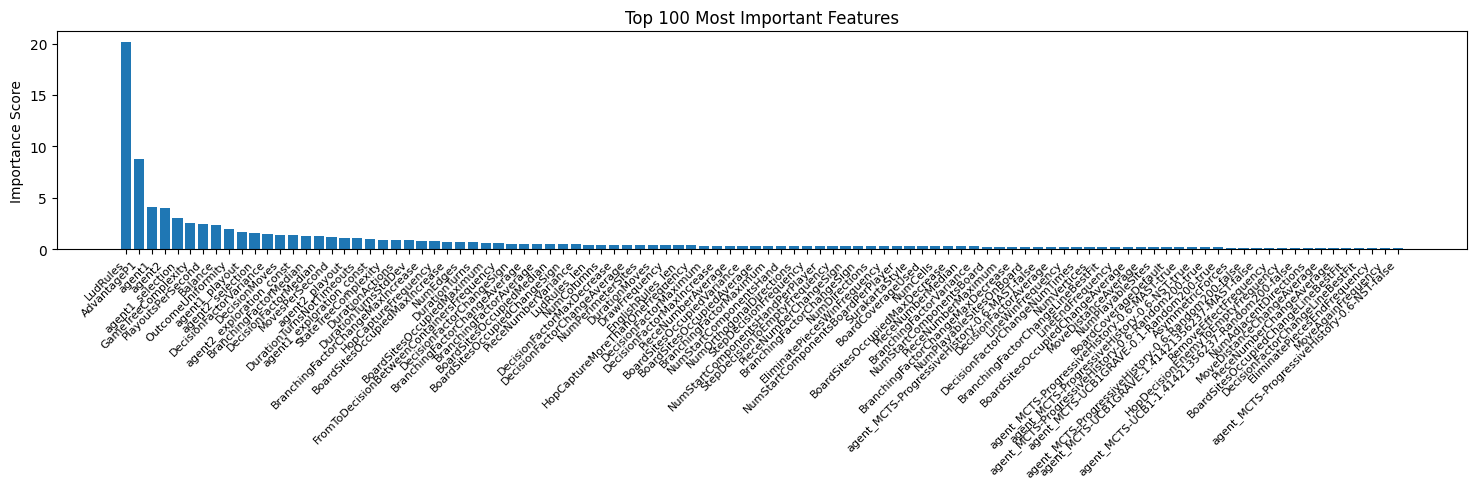

Fold 3 - RMSE: 0.42151345379438154
Fold 4


0:	learn: 0.6026421	test: 0.5884274	best: 0.5884274 (0)	total: 664ms	remaining: 33m 11s


50:	learn: 0.3896373	test: 0.4794996	best: 0.4794996 (50)	total: 33.6s	remaining: 32m 25s


100:	learn: 0.3534744	test: 0.4600964	best: 0.4600964 (100)	total: 1m 7s	remaining: 32m 12s


150:	learn: 0.3309454	test: 0.4498523	best: 0.4498523 (150)	total: 1m 40s	remaining: 31m 41s


200:	learn: 0.3151142	test: 0.4450781	best: 0.4449674 (199)	total: 2m 14s	remaining: 31m 7s


250:	learn: 0.3033072	test: 0.4419071	best: 0.4419071 (250)	total: 2m 47s	remaining: 30m 39s


300:	learn: 0.2938150	test: 0.4398579	best: 0.4398579 (300)	total: 3m 21s	remaining: 30m 4s


350:	learn: 0.2852343	test: 0.4378207	best: 0.4376654 (346)	total: 3m 55s	remaining: 29m 36s


400:	learn: 0.2783704	test: 0.4369977	best: 0.4369977 (400)	total: 4m 29s	remaining: 29m 7s


450:	learn: 0.2719265	test: 0.4355698	best: 0.4355698 (450)	total: 5m 3s	remaining: 28m 35s


500:	learn: 0.2659032	test: 0.4343003	best: 0.4343003 (500)	total: 5m 36s	remaining: 27m 59s


550:	learn: 0.2609334	test: 0.4337694	best: 0.4337694 (550)	total: 6m 10s	remaining: 27m 27s


600:	learn: 0.2567873	test: 0.4331227	best: 0.4331059 (593)	total: 6m 44s	remaining: 26m 53s


650:	learn: 0.2528673	test: 0.4325480	best: 0.4325480 (650)	total: 7m 18s	remaining: 26m 21s


700:	learn: 0.2491650	test: 0.4321722	best: 0.4321653 (699)	total: 7m 51s	remaining: 25m 47s


750:	learn: 0.2455348	test: 0.4319874	best: 0.4319598 (746)	total: 8m 26s	remaining: 25m 16s


800:	learn: 0.2423275	test: 0.4314120	best: 0.4314100 (799)	total: 9m	remaining: 24m 43s


850:	learn: 0.2395029	test: 0.4309440	best: 0.4309439 (848)	total: 9m 34s	remaining: 24m 10s


900:	learn: 0.2363786	test: 0.4306763	best: 0.4306763 (900)	total: 10m 8s	remaining: 23m 37s


950:	learn: 0.2335965	test: 0.4303217	best: 0.4303118 (949)	total: 10m 42s	remaining: 23m 3s


1000:	learn: 0.2310241	test: 0.4301912	best: 0.4301793 (997)	total: 11m 16s	remaining: 22m 30s


1050:	learn: 0.2285673	test: 0.4299055	best: 0.4299055 (1050)	total: 11m 50s	remaining: 21m 57s


1100:	learn: 0.2262826	test: 0.4295355	best: 0.4295355 (1100)	total: 12m 24s	remaining: 21m 23s


1150:	learn: 0.2242800	test: 0.4295230	best: 0.4295228 (1112)	total: 12m 58s	remaining: 20m 50s


1200:	learn: 0.2220717	test: 0.4293201	best: 0.4293201 (1200)	total: 13m 32s	remaining: 20m 16s


1250:	learn: 0.2201183	test: 0.4292326	best: 0.4291907 (1245)	total: 14m 6s	remaining: 19m 42s


1300:	learn: 0.2182509	test: 0.4290879	best: 0.4290845 (1298)	total: 14m 40s	remaining: 19m 9s


1350:	learn: 0.2164990	test: 0.4290212	best: 0.4290024 (1338)	total: 15m 14s	remaining: 18m 36s


1400:	learn: 0.2147074	test: 0.4289218	best: 0.4288999 (1395)	total: 15m 48s	remaining: 18m 2s


1450:	learn: 0.2129299	test: 0.4288149	best: 0.4288047 (1448)	total: 16m 22s	remaining: 17m 29s


1500:	learn: 0.2111523	test: 0.4287146	best: 0.4287093 (1496)	total: 16m 56s	remaining: 16m 55s


1550:	learn: 0.2093462	test: 0.4287197	best: 0.4286346 (1529)	total: 17m 30s	remaining: 16m 21s


1600:	learn: 0.2078041	test: 0.4286325	best: 0.4286325 (1600)	total: 18m 5s	remaining: 15m 48s


1650:	learn: 0.2061018	test: 0.4285342	best: 0.4285245 (1645)	total: 18m 39s	remaining: 15m 14s


1700:	learn: 0.2046798	test: 0.4284287	best: 0.4284287 (1700)	total: 19m 14s	remaining: 14m 41s


1750:	learn: 0.2031433	test: 0.4283606	best: 0.4283343 (1735)	total: 19m 48s	remaining: 14m 7s


1800:	learn: 0.2017392	test: 0.4282800	best: 0.4282539 (1788)	total: 20m 22s	remaining: 13m 34s


1850:	learn: 0.2001782	test: 0.4282259	best: 0.4282085 (1818)	total: 20m 57s	remaining: 13m


1900:	learn: 0.1986889	test: 0.4281999	best: 0.4281890 (1896)	total: 21m 31s	remaining: 12m 26s


1950:	learn: 0.1973292	test: 0.4281327	best: 0.4281291 (1946)	total: 22m 5s	remaining: 11m 52s


2000:	learn: 0.1960326	test: 0.4280450	best: 0.4280328 (1996)	total: 22m 39s	remaining: 11m 18s


2050:	learn: 0.1946969	test: 0.4279367	best: 0.4279364 (2043)	total: 23m 14s	remaining: 10m 45s


2100:	learn: 0.1934455	test: 0.4278986	best: 0.4278705 (2093)	total: 23m 48s	remaining: 10m 11s


2150:	learn: 0.1922089	test: 0.4278284	best: 0.4278085 (2146)	total: 24m 23s	remaining: 9m 37s


2200:	learn: 0.1909892	test: 0.4277727	best: 0.4277518 (2186)	total: 24m 57s	remaining: 9m 3s


2250:	learn: 0.1898420	test: 0.4276939	best: 0.4276906 (2246)	total: 25m 31s	remaining: 8m 29s


2300:	learn: 0.1886770	test: 0.4275731	best: 0.4275647 (2292)	total: 26m 5s	remaining: 7m 55s


2350:	learn: 0.1876693	test: 0.4275467	best: 0.4275372 (2349)	total: 26m 40s	remaining: 7m 21s


2400:	learn: 0.1864589	test: 0.4274667	best: 0.4274636 (2399)	total: 27m 14s	remaining: 6m 47s


2450:	learn: 0.1852282	test: 0.4274815	best: 0.4274268 (2431)	total: 27m 48s	remaining: 6m 13s


2500:	learn: 0.1840763	test: 0.4274006	best: 0.4274006 (2500)	total: 28m 23s	remaining: 5m 39s


2550:	learn: 0.1829557	test: 0.4273885	best: 0.4273763 (2532)	total: 28m 58s	remaining: 5m 5s


2600:	learn: 0.1819010	test: 0.4273530	best: 0.4273411 (2596)	total: 29m 32s	remaining: 4m 31s


2650:	learn: 0.1807682	test: 0.4273500	best: 0.4273305 (2609)	total: 30m 7s	remaining: 3m 57s


2700:	learn: 0.1797778	test: 0.4273728	best: 0.4273305 (2609)	total: 30m 41s	remaining: 3m 23s


2750:	learn: 0.1787732	test: 0.4273787	best: 0.4273305 (2609)	total: 31m 16s	remaining: 2m 49s


2800:	learn: 0.1777270	test: 0.4274615	best: 0.4273305 (2609)	total: 31m 50s	remaining: 2m 15s


2850:	learn: 0.1767261	test: 0.4275342	best: 0.4273305 (2609)	total: 32m 24s	remaining: 1m 41s


2900:	learn: 0.1756551	test: 0.4274918	best: 0.4273305 (2609)	total: 32m 59s	remaining: 1m 7s


2950:	learn: 0.1746660	test: 0.4275223	best: 0.4273305 (2609)	total: 33m 33s	remaining: 33.4s


2999:	learn: 0.1737160	test: 0.4275058	best: 0.4273305 (2609)	total: 34m 7s	remaining: 0us

bestTest = 0.42733052
bestIteration = 2609

Shrink model to first 2610 iterations.


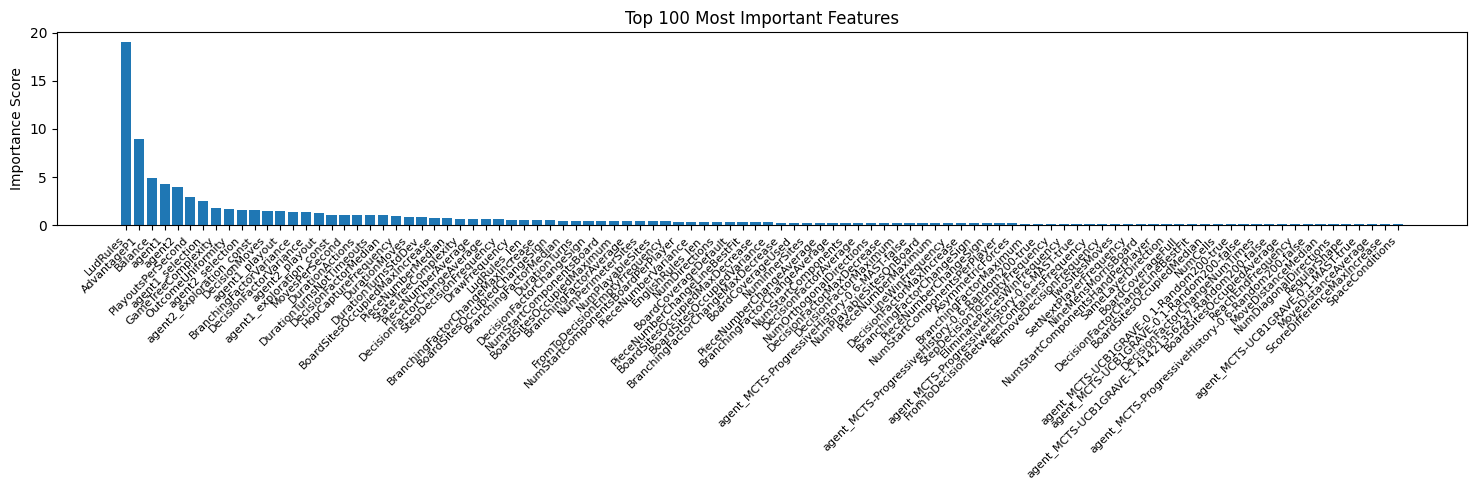

Fold 4 - RMSE: 0.4264477165162852
Fold 5


0:	learn: 0.6144846	test: 0.5446231	best: 0.5446231 (0)	total: 667ms	remaining: 33m 19s


50:	learn: 0.3963644	test: 0.4471555	best: 0.4471555 (50)	total: 33.5s	remaining: 32m 17s


100:	learn: 0.3595458	test: 0.4269053	best: 0.4269053 (100)	total: 1m 7s	remaining: 32m 17s


150:	learn: 0.3374144	test: 0.4167958	best: 0.4167487 (149)	total: 1m 40s	remaining: 31m 32s


200:	learn: 0.3209613	test: 0.4113686	best: 0.4113686 (200)	total: 2m 13s	remaining: 30m 53s


250:	learn: 0.3086409	test: 0.4082043	best: 0.4081713 (249)	total: 2m 46s	remaining: 30m 23s


300:	learn: 0.2987772	test: 0.4058954	best: 0.4058853 (293)	total: 3m 19s	remaining: 29m 49s


350:	learn: 0.2908330	test: 0.4038117	best: 0.4038117 (350)	total: 3m 53s	remaining: 29m 20s


400:	learn: 0.2833782	test: 0.4022042	best: 0.4021709 (398)	total: 4m 26s	remaining: 28m 49s


450:	learn: 0.2763873	test: 0.4011271	best: 0.4011074 (448)	total: 5m	remaining: 28m 16s


500:	learn: 0.2708087	test: 0.4003854	best: 0.4003854 (500)	total: 5m 33s	remaining: 27m 44s


550:	learn: 0.2656113	test: 0.3999406	best: 0.3999354 (548)	total: 6m 7s	remaining: 27m 12s


600:	learn: 0.2612650	test: 0.3989327	best: 0.3989327 (600)	total: 6m 41s	remaining: 26m 40s


650:	learn: 0.2569365	test: 0.3987423	best: 0.3987319 (643)	total: 7m 14s	remaining: 26m 6s


700:	learn: 0.2532738	test: 0.3985311	best: 0.3985233 (688)	total: 7m 47s	remaining: 25m 34s


750:	learn: 0.2497027	test: 0.3981810	best: 0.3981076 (733)	total: 8m 21s	remaining: 25m 1s


800:	learn: 0.2462343	test: 0.3977431	best: 0.3977290 (795)	total: 8m 55s	remaining: 24m 28s


850:	learn: 0.2432895	test: 0.3975150	best: 0.3974941 (848)	total: 9m 28s	remaining: 23m 56s


900:	learn: 0.2400385	test: 0.3972761	best: 0.3972677 (898)	total: 10m 2s	remaining: 23m 23s


950:	learn: 0.2372014	test: 0.3968868	best: 0.3968868 (950)	total: 10m 35s	remaining: 22m 48s


1000:	learn: 0.2345272	test: 0.3968156	best: 0.3967865 (993)	total: 11m 8s	remaining: 22m 15s


1050:	learn: 0.2318189	test: 0.3967817	best: 0.3966860 (1036)	total: 11m 42s	remaining: 21m 43s


1100:	learn: 0.2292723	test: 0.3966949	best: 0.3966393 (1084)	total: 12m 16s	remaining: 21m 9s


1150:	learn: 0.2270856	test: 0.3966311	best: 0.3966311 (1150)	total: 12m 49s	remaining: 20m 36s


1200:	learn: 0.2247704	test: 0.3964663	best: 0.3964499 (1197)	total: 13m 23s	remaining: 20m 3s


1250:	learn: 0.2228174	test: 0.3963943	best: 0.3963878 (1245)	total: 13m 57s	remaining: 19m 30s


1300:	learn: 0.2209188	test: 0.3962657	best: 0.3962644 (1299)	total: 14m 31s	remaining: 18m 57s


1350:	learn: 0.2188157	test: 0.3960950	best: 0.3960845 (1349)	total: 15m 5s	remaining: 18m 24s


1400:	learn: 0.2170117	test: 0.3960758	best: 0.3960224 (1382)	total: 15m 39s	remaining: 17m 51s


1450:	learn: 0.2152182	test: 0.3959308	best: 0.3959221 (1440)	total: 16m 12s	remaining: 17m 18s


1500:	learn: 0.2136950	test: 0.3957662	best: 0.3957383 (1493)	total: 16m 46s	remaining: 16m 45s


1550:	learn: 0.2120250	test: 0.3956610	best: 0.3956187 (1537)	total: 17m 20s	remaining: 16m 12s


1600:	learn: 0.2103070	test: 0.3956281	best: 0.3956187 (1537)	total: 17m 54s	remaining: 15m 38s


1650:	learn: 0.2087594	test: 0.3955393	best: 0.3955361 (1648)	total: 18m 28s	remaining: 15m 5s


1700:	learn: 0.2072556	test: 0.3954638	best: 0.3954638 (1700)	total: 19m 2s	remaining: 14m 32s


1750:	learn: 0.2056502	test: 0.3954403	best: 0.3954256 (1745)	total: 19m 36s	remaining: 13m 59s


1800:	learn: 0.2040463	test: 0.3954168	best: 0.3954109 (1782)	total: 20m 10s	remaining: 13m 25s


1850:	learn: 0.2027040	test: 0.3953287	best: 0.3953287 (1850)	total: 20m 44s	remaining: 12m 52s


1900:	learn: 0.2013848	test: 0.3953262	best: 0.3953158 (1854)	total: 21m 18s	remaining: 12m 19s


1950:	learn: 0.1999474	test: 0.3952888	best: 0.3952779 (1934)	total: 21m 52s	remaining: 11m 45s


2000:	learn: 0.1987786	test: 0.3952149	best: 0.3952056 (1992)	total: 22m 26s	remaining: 11m 12s


2050:	learn: 0.1974195	test: 0.3950830	best: 0.3950830 (2050)	total: 23m	remaining: 10m 38s


2100:	learn: 0.1962458	test: 0.3951210	best: 0.3950709 (2082)	total: 23m 34s	remaining: 10m 5s


2150:	learn: 0.1948841	test: 0.3951478	best: 0.3950709 (2082)	total: 24m 9s	remaining: 9m 31s


2200:	learn: 0.1936468	test: 0.3951344	best: 0.3950709 (2082)	total: 24m 42s	remaining: 8m 58s


2250:	learn: 0.1924044	test: 0.3952347	best: 0.3950709 (2082)	total: 25m 17s	remaining: 8m 24s


2300:	learn: 0.1911175	test: 0.3952775	best: 0.3950709 (2082)	total: 25m 50s	remaining: 7m 51s


2350:	learn: 0.1899382	test: 0.3951933	best: 0.3950709 (2082)	total: 26m 24s	remaining: 7m 17s


2400:	learn: 0.1886325	test: 0.3952007	best: 0.3950709 (2082)	total: 26m 58s	remaining: 6m 43s


2450:	learn: 0.1875807	test: 0.3951790	best: 0.3950709 (2082)	total: 27m 32s	remaining: 6m 10s


2500:	learn: 0.1864877	test: 0.3952257	best: 0.3950709 (2082)	total: 28m 6s	remaining: 5m 36s


2550:	learn: 0.1854130	test: 0.3952679	best: 0.3950709 (2082)	total: 28m 40s	remaining: 5m 2s


2600:	learn: 0.1841527	test: 0.3952482	best: 0.3950709 (2082)	total: 29m 14s	remaining: 4m 29s


2650:	learn: 0.1830392	test: 0.3952574	best: 0.3950709 (2082)	total: 29m 48s	remaining: 3m 55s


2700:	learn: 0.1818687	test: 0.3952151	best: 0.3950709 (2082)	total: 30m 22s	remaining: 3m 21s


2750:	learn: 0.1808716	test: 0.3952282	best: 0.3950709 (2082)	total: 30m 56s	remaining: 2m 47s


2800:	learn: 0.1799481	test: 0.3953048	best: 0.3950709 (2082)	total: 31m 30s	remaining: 2m 14s


2850:	learn: 0.1789816	test: 0.3953395	best: 0.3950709 (2082)	total: 32m 3s	remaining: 1m 40s


2900:	learn: 0.1779793	test: 0.3953635	best: 0.3950709 (2082)	total: 32m 37s	remaining: 1m 6s


2950:	learn: 0.1768560	test: 0.3953830	best: 0.3950709 (2082)	total: 33m 11s	remaining: 33.1s


2999:	learn: 0.1758747	test: 0.3954033	best: 0.3950709 (2082)	total: 33m 45s	remaining: 0us

bestTest = 0.3950708691
bestIteration = 2082

Shrink model to first 2083 iterations.


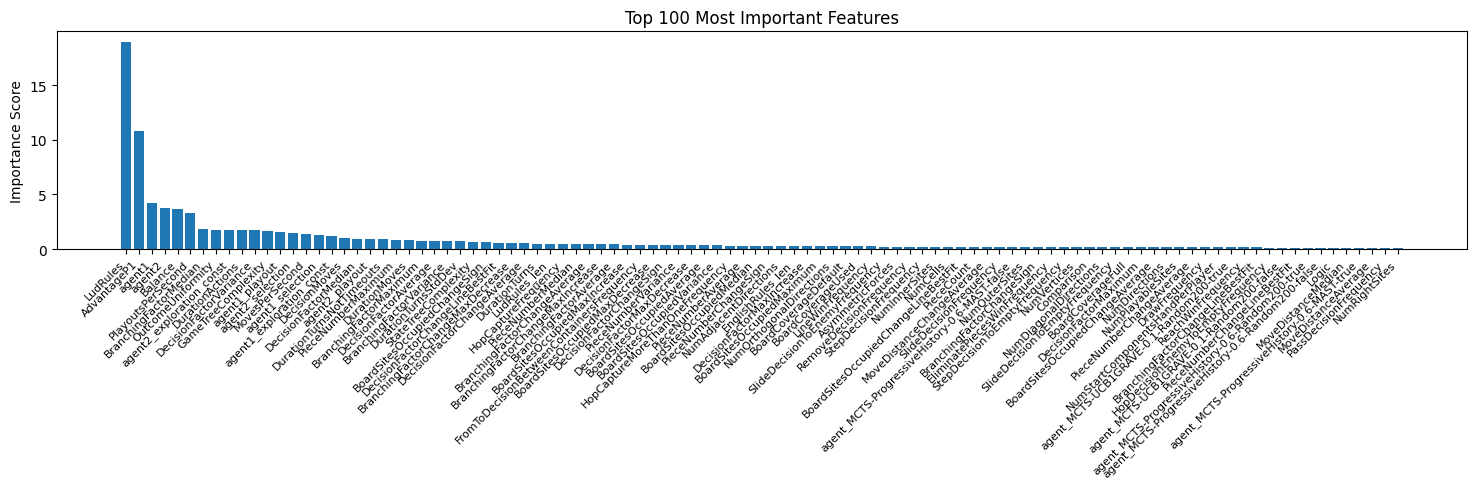

Fold 5 - RMSE: 0.39457976370783937
List of oof scores: [0.42058730048649756, 0.42837139632717464, 0.42151345379438154, 0.4264477165162852, 0.39457976370783937]
Average oof score: 0.41829992616643563


In [11]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_catboost_text_{fs_type}_cv1.parquet', index=False)

# save feature importance
# importance_df1.to_csv(path_results / 'feat_importance_catboost_cv1.csv', index=False)

Fold 1


0:	learn: 0.6157869	test: 0.5300457	best: 0.5300457 (0)	total: 657ms	remaining: 32m 49s


50:	learn: 0.4005871	test: 0.4501238	best: 0.4501238 (50)	total: 33.6s	remaining: 32m 21s


100:	learn: 0.3633006	test: 0.4360968	best: 0.4360968 (100)	total: 1m 6s	remaining: 31m 50s


150:	learn: 0.3408900	test: 0.4279908	best: 0.4279908 (150)	total: 1m 39s	remaining: 31m 25s


200:	learn: 0.3236302	test: 0.4225435	best: 0.4225435 (200)	total: 2m 12s	remaining: 30m 48s


250:	learn: 0.3121764	test: 0.4197217	best: 0.4197217 (250)	total: 2m 45s	remaining: 30m 14s


300:	learn: 0.3018414	test: 0.4172164	best: 0.4172164 (300)	total: 3m 18s	remaining: 29m 40s


350:	learn: 0.2944265	test: 0.4152090	best: 0.4152090 (350)	total: 3m 51s	remaining: 29m 7s


400:	learn: 0.2871384	test: 0.4142883	best: 0.4142883 (400)	total: 4m 24s	remaining: 28m 35s


450:	learn: 0.2801843	test: 0.4129785	best: 0.4129785 (450)	total: 4m 57s	remaining: 28m 4s


500:	learn: 0.2743070	test: 0.4122151	best: 0.4122151 (500)	total: 5m 31s	remaining: 27m 31s


550:	learn: 0.2692058	test: 0.4111766	best: 0.4111766 (550)	total: 6m 4s	remaining: 27m


600:	learn: 0.2644664	test: 0.4105284	best: 0.4105190 (599)	total: 6m 37s	remaining: 26m 28s


650:	learn: 0.2600871	test: 0.4099372	best: 0.4099337 (649)	total: 7m 11s	remaining: 25m 58s


700:	learn: 0.2563398	test: 0.4096409	best: 0.4096409 (700)	total: 7m 45s	remaining: 25m 26s


750:	learn: 0.2528269	test: 0.4094627	best: 0.4094058 (736)	total: 8m 18s	remaining: 24m 54s


800:	learn: 0.2496861	test: 0.4091938	best: 0.4091938 (800)	total: 8m 52s	remaining: 24m 22s


850:	learn: 0.2467544	test: 0.4088338	best: 0.4088126 (846)	total: 9m 25s	remaining: 23m 49s


900:	learn: 0.2439151	test: 0.4085665	best: 0.4085400 (895)	total: 9m 59s	remaining: 23m 16s


950:	learn: 0.2411666	test: 0.4084696	best: 0.4084621 (949)	total: 10m 33s	remaining: 22m 43s


1000:	learn: 0.2385438	test: 0.4082418	best: 0.4082412 (996)	total: 11m 6s	remaining: 22m 11s


1050:	learn: 0.2359023	test: 0.4080711	best: 0.4080711 (1050)	total: 11m 39s	remaining: 21m 38s


1100:	learn: 0.2333576	test: 0.4079714	best: 0.4079288 (1087)	total: 12m 13s	remaining: 21m 5s


1150:	learn: 0.2308910	test: 0.4078404	best: 0.4078387 (1149)	total: 12m 46s	remaining: 20m 31s


1200:	learn: 0.2286105	test: 0.4076884	best: 0.4076775 (1189)	total: 13m 20s	remaining: 19m 58s


1250:	learn: 0.2266764	test: 0.4075801	best: 0.4075718 (1248)	total: 13m 54s	remaining: 19m 26s


1300:	learn: 0.2245253	test: 0.4074021	best: 0.4073922 (1298)	total: 14m 28s	remaining: 18m 53s


1350:	learn: 0.2227219	test: 0.4073445	best: 0.4073298 (1330)	total: 15m 2s	remaining: 18m 21s


1400:	learn: 0.2207521	test: 0.4070596	best: 0.4070564 (1399)	total: 15m 36s	remaining: 17m 48s


1450:	learn: 0.2190949	test: 0.4070980	best: 0.4070142 (1422)	total: 16m 10s	remaining: 17m 15s


1500:	learn: 0.2176036	test: 0.4070265	best: 0.4070034 (1485)	total: 16m 44s	remaining: 16m 42s


1550:	learn: 0.2157760	test: 0.4069950	best: 0.4069327 (1538)	total: 17m 18s	remaining: 16m 10s


1600:	learn: 0.2140592	test: 0.4069081	best: 0.4068683 (1585)	total: 17m 52s	remaining: 15m 37s


1650:	learn: 0.2124381	test: 0.4069237	best: 0.4068683 (1585)	total: 18m 26s	remaining: 15m 3s


1700:	learn: 0.2107082	test: 0.4069120	best: 0.4068683 (1585)	total: 19m	remaining: 14m 30s


1750:	learn: 0.2091321	test: 0.4069346	best: 0.4068683 (1585)	total: 19m 34s	remaining: 13m 57s


1800:	learn: 0.2074703	test: 0.4068094	best: 0.4068094 (1800)	total: 20m 8s	remaining: 13m 24s


1850:	learn: 0.2059620	test: 0.4068183	best: 0.4068004 (1801)	total: 20m 42s	remaining: 12m 50s


1900:	learn: 0.2045892	test: 0.4067654	best: 0.4067424 (1897)	total: 21m 15s	remaining: 12m 17s


1950:	learn: 0.2031371	test: 0.4067888	best: 0.4067205 (1923)	total: 21m 49s	remaining: 11m 44s


2000:	learn: 0.2015858	test: 0.4067455	best: 0.4067205 (1923)	total: 22m 23s	remaining: 11m 10s


2050:	learn: 0.2000151	test: 0.4067349	best: 0.4067069 (2038)	total: 22m 56s	remaining: 10m 37s


2100:	learn: 0.1987163	test: 0.4066806	best: 0.4066453 (2082)	total: 23m 30s	remaining: 10m 3s


2150:	learn: 0.1973642	test: 0.4066951	best: 0.4066453 (2082)	total: 24m 4s	remaining: 9m 30s


2200:	learn: 0.1960798	test: 0.4065733	best: 0.4065733 (2200)	total: 24m 38s	remaining: 8m 56s


2250:	learn: 0.1946397	test: 0.4065180	best: 0.4065180 (2250)	total: 25m 12s	remaining: 8m 23s


2300:	learn: 0.1932891	test: 0.4064382	best: 0.4064232 (2298)	total: 25m 46s	remaining: 7m 49s


2350:	learn: 0.1918968	test: 0.4064181	best: 0.4064001 (2328)	total: 26m 20s	remaining: 7m 16s


2400:	learn: 0.1907657	test: 0.4063884	best: 0.4063884 (2400)	total: 26m 53s	remaining: 6m 42s


2450:	learn: 0.1896417	test: 0.4063705	best: 0.4063669 (2420)	total: 27m 28s	remaining: 6m 9s


2500:	learn: 0.1884010	test: 0.4063813	best: 0.4063391 (2476)	total: 28m 2s	remaining: 5m 35s


2550:	learn: 0.1873857	test: 0.4063723	best: 0.4063391 (2476)	total: 28m 36s	remaining: 5m 2s


2600:	learn: 0.1862924	test: 0.4063647	best: 0.4063391 (2476)	total: 29m 10s	remaining: 4m 28s


2650:	learn: 0.1850737	test: 0.4063310	best: 0.4063302 (2649)	total: 29m 44s	remaining: 3m 54s


2700:	learn: 0.1839115	test: 0.4063417	best: 0.4063302 (2649)	total: 30m 18s	remaining: 3m 21s


2750:	learn: 0.1828348	test: 0.4063047	best: 0.4063047 (2750)	total: 30m 52s	remaining: 2m 47s


2800:	learn: 0.1815473	test: 0.4062826	best: 0.4062708 (2795)	total: 31m 26s	remaining: 2m 13s


2850:	learn: 0.1804987	test: 0.4062477	best: 0.4062397 (2848)	total: 32m	remaining: 1m 40s


2900:	learn: 0.1794472	test: 0.4062121	best: 0.4062115 (2898)	total: 32m 34s	remaining: 1m 6s


2950:	learn: 0.1784272	test: 0.4061892	best: 0.4061702 (2928)	total: 33m 8s	remaining: 33s


2999:	learn: 0.1774212	test: 0.4062127	best: 0.4061702 (2928)	total: 33m 41s	remaining: 0us

bestTest = 0.406170188
bestIteration = 2928

Shrink model to first 2929 iterations.


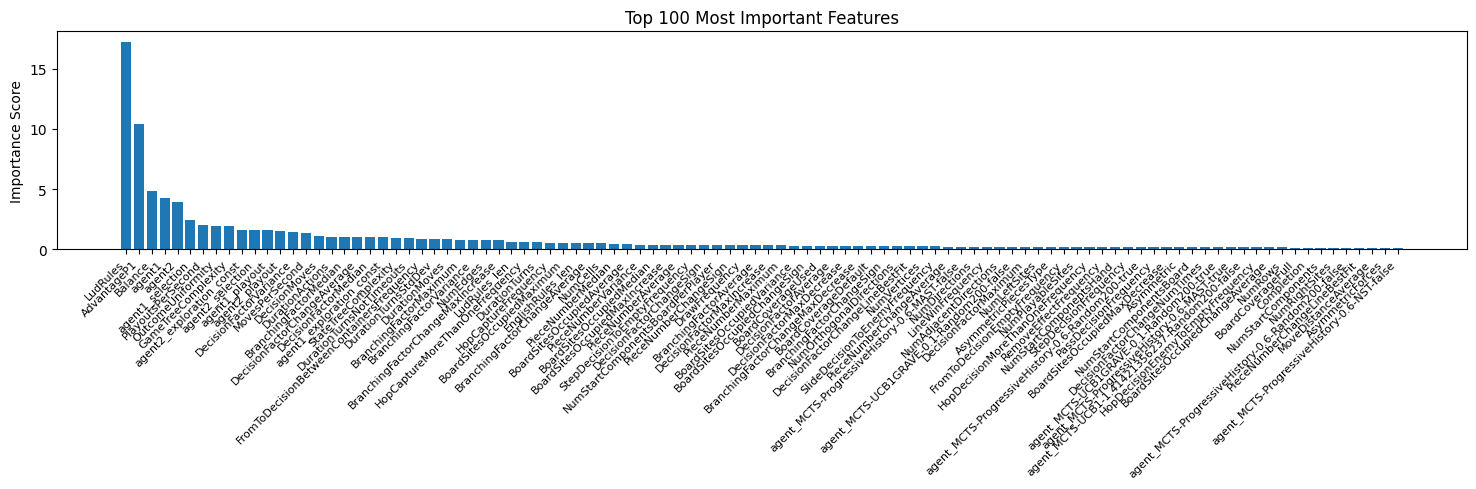

Fold 1 - RMSE: 0.4058196036153148
Fold 2


0:	learn: 0.6131002	test: 0.5375150	best: 0.5375150 (0)	total: 669ms	remaining: 33m 26s


50:	learn: 0.3938582	test: 0.4287489	best: 0.4287489 (50)	total: 34.6s	remaining: 33m 23s


100:	learn: 0.3562445	test: 0.4150752	best: 0.4150752 (100)	total: 1m 7s	remaining: 32m 30s


150:	learn: 0.3343591	test: 0.4077291	best: 0.4077291 (150)	total: 1m 41s	remaining: 31m 50s


200:	learn: 0.3189687	test: 0.4041632	best: 0.4041632 (200)	total: 2m 14s	remaining: 31m 9s


250:	learn: 0.3058047	test: 0.4026742	best: 0.4025507 (246)	total: 2m 47s	remaining: 30m 35s


300:	learn: 0.2957011	test: 0.4009553	best: 0.4009553 (300)	total: 3m 21s	remaining: 30m 7s


350:	learn: 0.2875016	test: 0.3997673	best: 0.3997673 (350)	total: 3m 54s	remaining: 29m 33s


400:	learn: 0.2800795	test: 0.3989711	best: 0.3989711 (400)	total: 4m 28s	remaining: 29m 1s


450:	learn: 0.2733169	test: 0.3981566	best: 0.3981125 (443)	total: 5m 2s	remaining: 28m 27s


500:	learn: 0.2675204	test: 0.3979101	best: 0.3979101 (500)	total: 5m 35s	remaining: 27m 55s


550:	learn: 0.2625750	test: 0.3973652	best: 0.3973236 (538)	total: 6m 9s	remaining: 27m 21s


600:	learn: 0.2580890	test: 0.3972632	best: 0.3972564 (594)	total: 6m 43s	remaining: 26m 49s


650:	learn: 0.2535702	test: 0.3971348	best: 0.3971139 (649)	total: 7m 17s	remaining: 26m 17s


700:	learn: 0.2498145	test: 0.3969113	best: 0.3968716 (696)	total: 7m 51s	remaining: 25m 45s


750:	learn: 0.2464652	test: 0.3967010	best: 0.3966545 (743)	total: 8m 25s	remaining: 25m 12s


800:	learn: 0.2431636	test: 0.3965377	best: 0.3964829 (796)	total: 8m 59s	remaining: 24m 40s


850:	learn: 0.2398720	test: 0.3964628	best: 0.3964210 (846)	total: 9m 33s	remaining: 24m 7s


900:	learn: 0.2366293	test: 0.3962924	best: 0.3962924 (900)	total: 10m 6s	remaining: 23m 33s


950:	learn: 0.2338819	test: 0.3962859	best: 0.3962406 (937)	total: 10m 40s	remaining: 23m


1000:	learn: 0.2311813	test: 0.3961600	best: 0.3961071 (985)	total: 11m 14s	remaining: 22m 27s


1050:	learn: 0.2290184	test: 0.3959765	best: 0.3959592 (1048)	total: 11m 49s	remaining: 21m 55s


1100:	learn: 0.2267316	test: 0.3960911	best: 0.3959592 (1048)	total: 12m 23s	remaining: 21m 21s


1150:	learn: 0.2245312	test: 0.3961382	best: 0.3959592 (1048)	total: 12m 57s	remaining: 20m 48s


1200:	learn: 0.2223741	test: 0.3962200	best: 0.3959592 (1048)	total: 13m 31s	remaining: 20m 15s


1250:	learn: 0.2202419	test: 0.3961732	best: 0.3959592 (1048)	total: 14m 5s	remaining: 19m 41s


1300:	learn: 0.2182767	test: 0.3962942	best: 0.3959592 (1048)	total: 14m 39s	remaining: 19m 8s


1350:	learn: 0.2163436	test: 0.3962972	best: 0.3959592 (1048)	total: 15m 13s	remaining: 18m 35s


1400:	learn: 0.2145977	test: 0.3963385	best: 0.3959592 (1048)	total: 15m 48s	remaining: 18m 2s


1450:	learn: 0.2125799	test: 0.3962209	best: 0.3959592 (1048)	total: 16m 21s	remaining: 17m 28s


1500:	learn: 0.2109643	test: 0.3961315	best: 0.3959592 (1048)	total: 16m 56s	remaining: 16m 54s


1550:	learn: 0.2093473	test: 0.3961764	best: 0.3959592 (1048)	total: 17m 30s	remaining: 16m 21s


1600:	learn: 0.2075740	test: 0.3960538	best: 0.3959592 (1048)	total: 18m 4s	remaining: 15m 47s


1650:	learn: 0.2058204	test: 0.3960830	best: 0.3959592 (1048)	total: 18m 38s	remaining: 15m 14s


1700:	learn: 0.2042938	test: 0.3960578	best: 0.3959592 (1048)	total: 19m 12s	remaining: 14m 40s


1750:	learn: 0.2027230	test: 0.3961137	best: 0.3959592 (1048)	total: 19m 46s	remaining: 14m 6s


1800:	learn: 0.2012303	test: 0.3960895	best: 0.3959592 (1048)	total: 20m 21s	remaining: 13m 32s


1850:	learn: 0.1998729	test: 0.3960450	best: 0.3959592 (1048)	total: 20m 55s	remaining: 12m 59s


1900:	learn: 0.1983451	test: 0.3960087	best: 0.3959592 (1048)	total: 21m 29s	remaining: 12m 25s


1950:	learn: 0.1970106	test: 0.3960758	best: 0.3959592 (1048)	total: 22m 3s	remaining: 11m 51s


2000:	learn: 0.1957531	test: 0.3961307	best: 0.3959592 (1048)	total: 22m 38s	remaining: 11m 18s


2050:	learn: 0.1943227	test: 0.3962001	best: 0.3959592 (1048)	total: 23m 12s	remaining: 10m 44s


2100:	learn: 0.1928106	test: 0.3962232	best: 0.3959592 (1048)	total: 23m 46s	remaining: 10m 10s


2150:	learn: 0.1914432	test: 0.3962691	best: 0.3959592 (1048)	total: 24m 20s	remaining: 9m 36s


2200:	learn: 0.1901488	test: 0.3962936	best: 0.3959592 (1048)	total: 24m 54s	remaining: 9m 2s


2250:	learn: 0.1888435	test: 0.3963345	best: 0.3959592 (1048)	total: 25m 29s	remaining: 8m 28s


2300:	learn: 0.1875645	test: 0.3962980	best: 0.3959592 (1048)	total: 26m 3s	remaining: 7m 54s


2350:	learn: 0.1863492	test: 0.3963132	best: 0.3959592 (1048)	total: 26m 37s	remaining: 7m 20s


2400:	learn: 0.1851936	test: 0.3963084	best: 0.3959592 (1048)	total: 27m 11s	remaining: 6m 47s


2450:	learn: 0.1841565	test: 0.3963264	best: 0.3959592 (1048)	total: 27m 46s	remaining: 6m 13s


2500:	learn: 0.1830319	test: 0.3963367	best: 0.3959592 (1048)	total: 28m 20s	remaining: 5m 39s


2550:	learn: 0.1819500	test: 0.3964469	best: 0.3959592 (1048)	total: 28m 54s	remaining: 5m 5s


2600:	learn: 0.1807776	test: 0.3964605	best: 0.3959592 (1048)	total: 29m 28s	remaining: 4m 31s


2650:	learn: 0.1796156	test: 0.3964490	best: 0.3959592 (1048)	total: 30m 2s	remaining: 3m 57s


2700:	learn: 0.1785084	test: 0.3964583	best: 0.3959592 (1048)	total: 30m 36s	remaining: 3m 23s


2750:	learn: 0.1774457	test: 0.3965089	best: 0.3959592 (1048)	total: 31m 11s	remaining: 2m 49s


2800:	learn: 0.1764111	test: 0.3965099	best: 0.3959592 (1048)	total: 31m 45s	remaining: 2m 15s


2850:	learn: 0.1753327	test: 0.3965386	best: 0.3959592 (1048)	total: 32m 19s	remaining: 1m 41s


2900:	learn: 0.1743148	test: 0.3965814	best: 0.3959592 (1048)	total: 32m 54s	remaining: 1m 7s


2950:	learn: 0.1732468	test: 0.3966045	best: 0.3959592 (1048)	total: 33m 28s	remaining: 33.3s


2999:	learn: 0.1722127	test: 0.3966353	best: 0.3959592 (1048)	total: 34m 2s	remaining: 0us

bestTest = 0.3959591811
bestIteration = 1048

Shrink model to first 1049 iterations.


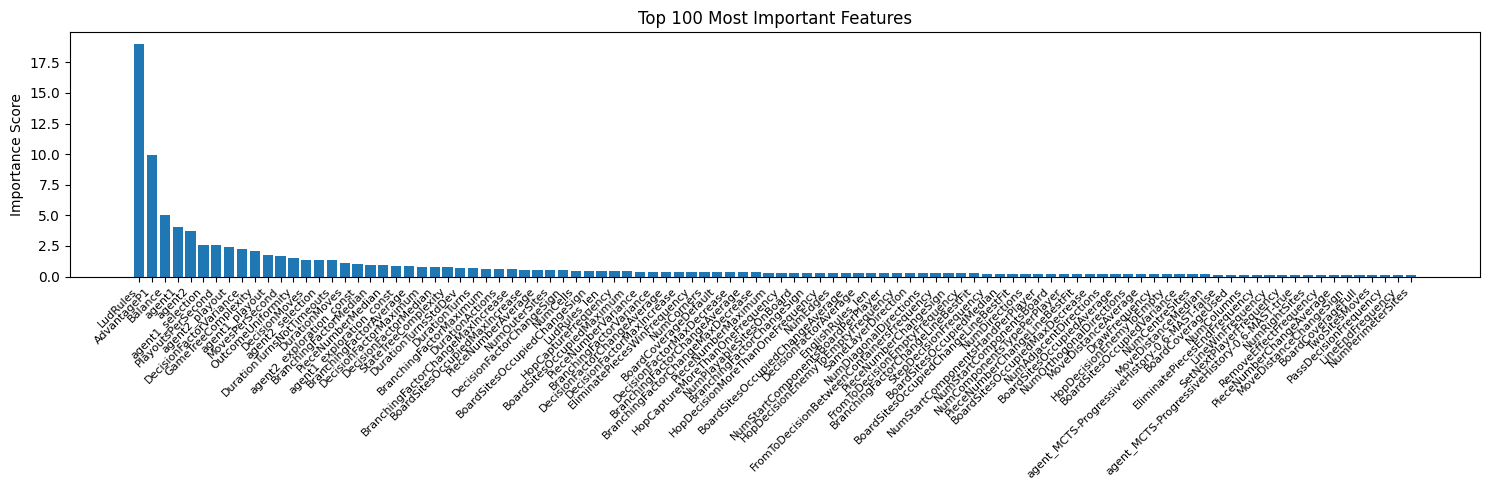

Fold 2 - RMSE: 0.3955414530872851
Fold 3


0:	learn: 0.5995221	test: 0.6072690	best: 0.6072690 (0)	total: 655ms	remaining: 32m 45s


50:	learn: 0.3830016	test: 0.4888619	best: 0.4888619 (50)	total: 32.3s	remaining: 31m 8s


100:	learn: 0.3467286	test: 0.4669476	best: 0.4669476 (100)	total: 1m 4s	remaining: 30m 58s


150:	learn: 0.3255188	test: 0.4563509	best: 0.4563509 (150)	total: 1m 36s	remaining: 30m 23s


200:	learn: 0.3113707	test: 0.4510614	best: 0.4510614 (200)	total: 2m 8s	remaining: 29m 45s


250:	learn: 0.2988569	test: 0.4471472	best: 0.4471445 (249)	total: 2m 39s	remaining: 29m 11s


300:	learn: 0.2892781	test: 0.4448759	best: 0.4448759 (300)	total: 3m 11s	remaining: 28m 40s


350:	learn: 0.2809007	test: 0.4432120	best: 0.4432116 (349)	total: 3m 43s	remaining: 28m 10s


400:	learn: 0.2740640	test: 0.4415796	best: 0.4415796 (400)	total: 4m 15s	remaining: 27m 36s


450:	learn: 0.2684403	test: 0.4405304	best: 0.4405304 (450)	total: 4m 47s	remaining: 27m 7s


500:	learn: 0.2628299	test: 0.4400696	best: 0.4399153 (492)	total: 5m 19s	remaining: 26m 34s


550:	learn: 0.2581052	test: 0.4392883	best: 0.4392829 (547)	total: 5m 51s	remaining: 26m 3s


600:	learn: 0.2536706	test: 0.4389249	best: 0.4389249 (600)	total: 6m 23s	remaining: 25m 31s


650:	learn: 0.2494896	test: 0.4381593	best: 0.4381593 (650)	total: 6m 55s	remaining: 25m


700:	learn: 0.2460162	test: 0.4377970	best: 0.4377839 (680)	total: 7m 28s	remaining: 24m 29s


750:	learn: 0.2426062	test: 0.4373868	best: 0.4373868 (750)	total: 8m	remaining: 23m 59s


800:	learn: 0.2394079	test: 0.4370880	best: 0.4370880 (800)	total: 8m 33s	remaining: 23m 28s


850:	learn: 0.2362328	test: 0.4367310	best: 0.4367310 (850)	total: 9m 5s	remaining: 22m 58s


900:	learn: 0.2334432	test: 0.4363683	best: 0.4363683 (900)	total: 9m 37s	remaining: 22m 26s


950:	learn: 0.2309717	test: 0.4363974	best: 0.4363432 (907)	total: 10m 10s	remaining: 21m 55s


1000:	learn: 0.2284473	test: 0.4362059	best: 0.4361912 (996)	total: 10m 42s	remaining: 21m 23s


1050:	learn: 0.2260944	test: 0.4360160	best: 0.4359433 (1038)	total: 11m 15s	remaining: 20m 53s


1100:	learn: 0.2239380	test: 0.4358077	best: 0.4358077 (1100)	total: 11m 48s	remaining: 20m 22s


1150:	learn: 0.2219438	test: 0.4354984	best: 0.4354984 (1150)	total: 12m 21s	remaining: 19m 50s


1200:	learn: 0.2200898	test: 0.4354413	best: 0.4354257 (1199)	total: 12m 53s	remaining: 19m 19s


1250:	learn: 0.2182572	test: 0.4352294	best: 0.4352294 (1250)	total: 13m 27s	remaining: 18m 48s


1300:	learn: 0.2163157	test: 0.4352730	best: 0.4351899 (1260)	total: 13m 59s	remaining: 18m 16s


1350:	learn: 0.2146669	test: 0.4353698	best: 0.4351899 (1260)	total: 14m 32s	remaining: 17m 44s


1400:	learn: 0.2129762	test: 0.4351495	best: 0.4351495 (1400)	total: 15m 5s	remaining: 17m 13s


1450:	learn: 0.2113811	test: 0.4350585	best: 0.4350133 (1443)	total: 15m 37s	remaining: 16m 40s


1500:	learn: 0.2098965	test: 0.4349800	best: 0.4349541 (1496)	total: 16m 10s	remaining: 16m 9s


1550:	learn: 0.2083326	test: 0.4348976	best: 0.4348913 (1529)	total: 16m 43s	remaining: 15m 37s


1600:	learn: 0.2069055	test: 0.4348446	best: 0.4348446 (1600)	total: 17m 15s	remaining: 15m 5s


1650:	learn: 0.2054016	test: 0.4347847	best: 0.4347847 (1650)	total: 17m 48s	remaining: 14m 33s


1700:	learn: 0.2038169	test: 0.4348206	best: 0.4347625 (1660)	total: 18m 21s	remaining: 14m


1750:	learn: 0.2023086	test: 0.4347354	best: 0.4346906 (1731)	total: 18m 53s	remaining: 13m 28s


1800:	learn: 0.2008162	test: 0.4346948	best: 0.4346760 (1789)	total: 19m 26s	remaining: 12m 56s


1850:	learn: 0.1994409	test: 0.4346690	best: 0.4346297 (1843)	total: 19m 58s	remaining: 12m 24s


1900:	learn: 0.1979491	test: 0.4345953	best: 0.4345924 (1894)	total: 20m 31s	remaining: 11m 52s


1950:	learn: 0.1966902	test: 0.4346069	best: 0.4345737 (1943)	total: 21m 4s	remaining: 11m 19s


2000:	learn: 0.1954267	test: 0.4345781	best: 0.4345737 (1943)	total: 21m 37s	remaining: 10m 47s


2050:	learn: 0.1941029	test: 0.4345974	best: 0.4345297 (2016)	total: 22m 10s	remaining: 10m 15s


2100:	learn: 0.1928863	test: 0.4345999	best: 0.4345297 (2016)	total: 22m 43s	remaining: 9m 43s


2150:	learn: 0.1917116	test: 0.4345711	best: 0.4345297 (2016)	total: 23m 15s	remaining: 9m 10s


2200:	learn: 0.1904821	test: 0.4345283	best: 0.4345252 (2195)	total: 23m 48s	remaining: 8m 38s


2250:	learn: 0.1892106	test: 0.4345417	best: 0.4345079 (2209)	total: 24m 20s	remaining: 8m 6s


2300:	learn: 0.1880120	test: 0.4344508	best: 0.4344472 (2299)	total: 24m 53s	remaining: 7m 33s


2350:	learn: 0.1866475	test: 0.4343891	best: 0.4343891 (2350)	total: 25m 25s	remaining: 7m 1s


2400:	learn: 0.1853626	test: 0.4343177	best: 0.4343110 (2378)	total: 25m 58s	remaining: 6m 28s


2450:	learn: 0.1842383	test: 0.4342813	best: 0.4342604 (2431)	total: 26m 30s	remaining: 5m 56s


2500:	learn: 0.1831478	test: 0.4342422	best: 0.4342422 (2500)	total: 27m 2s	remaining: 5m 23s


2550:	learn: 0.1820637	test: 0.4342428	best: 0.4342096 (2520)	total: 27m 35s	remaining: 4m 51s


2600:	learn: 0.1809791	test: 0.4342719	best: 0.4342096 (2520)	total: 28m 8s	remaining: 4m 18s


2650:	learn: 0.1798384	test: 0.4342158	best: 0.4342096 (2520)	total: 28m 41s	remaining: 3m 46s


2700:	learn: 0.1787331	test: 0.4341673	best: 0.4341595 (2698)	total: 29m 14s	remaining: 3m 14s


2750:	learn: 0.1777131	test: 0.4341342	best: 0.4341045 (2712)	total: 29m 47s	remaining: 2m 41s


2800:	learn: 0.1767284	test: 0.4341310	best: 0.4341045 (2712)	total: 30m 19s	remaining: 2m 9s


2850:	learn: 0.1757071	test: 0.4340432	best: 0.4340394 (2849)	total: 30m 52s	remaining: 1m 36s


2900:	learn: 0.1747526	test: 0.4340760	best: 0.4340394 (2849)	total: 31m 25s	remaining: 1m 4s


2950:	learn: 0.1737314	test: 0.4339888	best: 0.4339888 (2950)	total: 31m 57s	remaining: 31.8s


2999:	learn: 0.1728030	test: 0.4339564	best: 0.4339436 (2973)	total: 32m 29s	remaining: 0us

bestTest = 0.4339436465
bestIteration = 2973

Shrink model to first 2974 iterations.


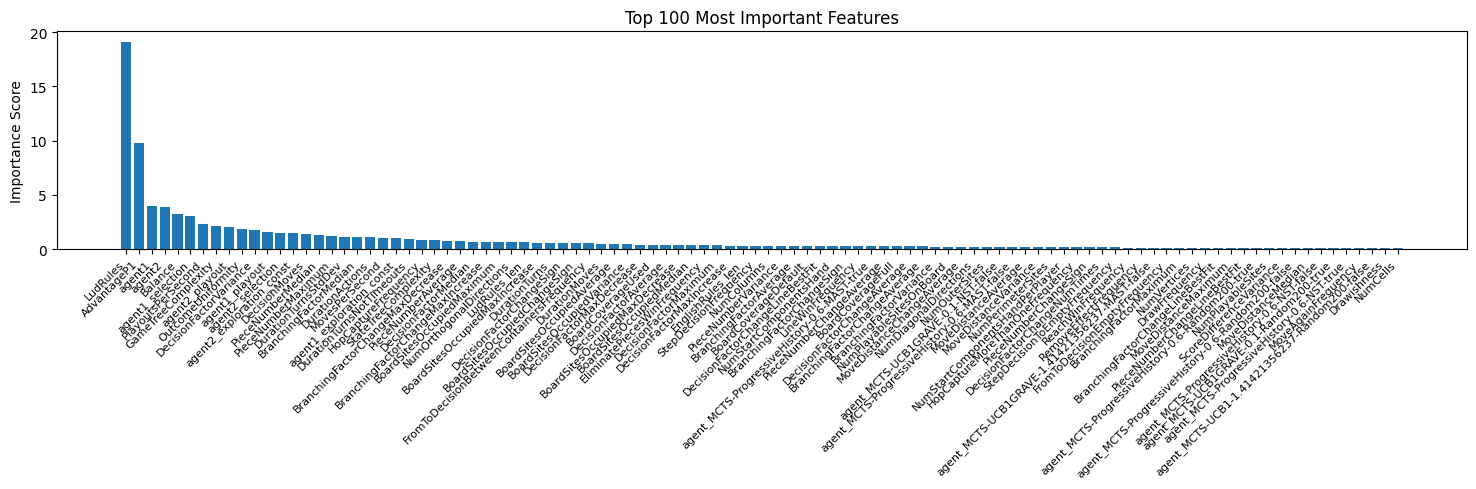

Fold 3 - RMSE: 0.4328678847382769
Fold 4


0:	learn: 0.6012765	test: 0.5953065	best: 0.5953065 (0)	total: 650ms	remaining: 32m 29s


50:	learn: 0.3926980	test: 0.4753489	best: 0.4753489 (50)	total: 33.7s	remaining: 32m 30s


100:	learn: 0.3574112	test: 0.4571417	best: 0.4571417 (100)	total: 1m 7s	remaining: 32m 24s


150:	learn: 0.3349933	test: 0.4456314	best: 0.4456314 (150)	total: 1m 41s	remaining: 31m 56s


200:	learn: 0.3182937	test: 0.4401305	best: 0.4401305 (200)	total: 2m 15s	remaining: 31m 22s


250:	learn: 0.3052673	test: 0.4370846	best: 0.4370846 (250)	total: 2m 48s	remaining: 30m 45s


300:	learn: 0.2951252	test: 0.4345869	best: 0.4345030 (297)	total: 3m 22s	remaining: 30m 12s


350:	learn: 0.2867587	test: 0.4330007	best: 0.4330007 (350)	total: 3m 56s	remaining: 29m 42s


400:	learn: 0.2801720	test: 0.4319579	best: 0.4319579 (400)	total: 4m 30s	remaining: 29m 13s


450:	learn: 0.2742859	test: 0.4312370	best: 0.4312206 (449)	total: 5m 4s	remaining: 28m 40s


500:	learn: 0.2692466	test: 0.4303664	best: 0.4303664 (500)	total: 5m 39s	remaining: 28m 10s


550:	learn: 0.2644305	test: 0.4298331	best: 0.4298331 (550)	total: 6m 13s	remaining: 27m 38s


600:	learn: 0.2602752	test: 0.4296818	best: 0.4296513 (589)	total: 6m 47s	remaining: 27m 8s


650:	learn: 0.2564485	test: 0.4293050	best: 0.4293050 (650)	total: 7m 22s	remaining: 26m 35s


700:	learn: 0.2526345	test: 0.4286533	best: 0.4286533 (700)	total: 7m 56s	remaining: 26m 2s


750:	learn: 0.2492081	test: 0.4285985	best: 0.4285799 (740)	total: 8m 31s	remaining: 25m 30s


800:	learn: 0.2462015	test: 0.4282851	best: 0.4282796 (799)	total: 9m 5s	remaining: 24m 58s


850:	learn: 0.2430460	test: 0.4280743	best: 0.4280743 (850)	total: 9m 40s	remaining: 24m 25s


900:	learn: 0.2403654	test: 0.4277333	best: 0.4277150 (890)	total: 10m 15s	remaining: 23m 52s


950:	learn: 0.2380173	test: 0.4274472	best: 0.4274472 (950)	total: 10m 49s	remaining: 23m 19s


1000:	learn: 0.2357932	test: 0.4271721	best: 0.4271721 (1000)	total: 11m 23s	remaining: 22m 45s


1050:	learn: 0.2334713	test: 0.4268735	best: 0.4268646 (1049)	total: 11m 58s	remaining: 22m 12s


1100:	learn: 0.2312626	test: 0.4268734	best: 0.4268646 (1049)	total: 12m 32s	remaining: 21m 38s


1150:	learn: 0.2290278	test: 0.4267249	best: 0.4267245 (1149)	total: 13m 6s	remaining: 21m 4s


1200:	learn: 0.2270992	test: 0.4266001	best: 0.4265797 (1198)	total: 13m 41s	remaining: 20m 30s


1250:	learn: 0.2250916	test: 0.4263885	best: 0.4263880 (1248)	total: 14m 16s	remaining: 19m 56s


1300:	learn: 0.2232164	test: 0.4262535	best: 0.4262535 (1300)	total: 14m 51s	remaining: 19m 23s


1350:	learn: 0.2215262	test: 0.4261243	best: 0.4261243 (1350)	total: 15m 25s	remaining: 18m 50s


1400:	learn: 0.2196857	test: 0.4259842	best: 0.4259842 (1400)	total: 16m	remaining: 18m 16s


1450:	learn: 0.2179331	test: 0.4260079	best: 0.4259842 (1400)	total: 16m 35s	remaining: 17m 42s


1500:	learn: 0.2161669	test: 0.4258837	best: 0.4258580 (1485)	total: 17m 10s	remaining: 17m 8s


1550:	learn: 0.2144749	test: 0.4257473	best: 0.4257416 (1548)	total: 17m 44s	remaining: 16m 34s


1600:	learn: 0.2128300	test: 0.4256504	best: 0.4256504 (1600)	total: 18m 19s	remaining: 16m


1650:	learn: 0.2112479	test: 0.4254782	best: 0.4254631 (1644)	total: 18m 53s	remaining: 15m 26s


1700:	learn: 0.2098315	test: 0.4254502	best: 0.4254502 (1700)	total: 19m 28s	remaining: 14m 52s


1750:	learn: 0.2084218	test: 0.4254015	best: 0.4253894 (1709)	total: 20m 2s	remaining: 14m 17s


1800:	learn: 0.2069943	test: 0.4253848	best: 0.4253610 (1775)	total: 20m 37s	remaining: 13m 43s


1850:	learn: 0.2056764	test: 0.4253680	best: 0.4253598 (1849)	total: 21m 11s	remaining: 13m 9s


1900:	learn: 0.2042409	test: 0.4252258	best: 0.4252131 (1899)	total: 21m 46s	remaining: 12m 35s


1950:	learn: 0.2029062	test: 0.4251986	best: 0.4251355 (1938)	total: 22m 20s	remaining: 12m


2000:	learn: 0.2015466	test: 0.4251789	best: 0.4251355 (1938)	total: 22m 54s	remaining: 11m 26s


2050:	learn: 0.2001655	test: 0.4250971	best: 0.4250693 (2044)	total: 23m 29s	remaining: 10m 51s


2100:	learn: 0.1988740	test: 0.4250905	best: 0.4250693 (2044)	total: 24m 3s	remaining: 10m 17s


2150:	learn: 0.1976238	test: 0.4250664	best: 0.4250630 (2145)	total: 24m 38s	remaining: 9m 43s


2200:	learn: 0.1964250	test: 0.4250164	best: 0.4249805 (2173)	total: 25m 12s	remaining: 9m 9s


2250:	learn: 0.1952365	test: 0.4249983	best: 0.4249754 (2247)	total: 25m 47s	remaining: 8m 34s


2300:	learn: 0.1940509	test: 0.4249826	best: 0.4249754 (2247)	total: 26m 22s	remaining: 8m


2350:	learn: 0.1927776	test: 0.4249646	best: 0.4249165 (2312)	total: 26m 56s	remaining: 7m 26s


2400:	learn: 0.1915395	test: 0.4249831	best: 0.4249165 (2312)	total: 27m 31s	remaining: 6m 51s


2450:	learn: 0.1902848	test: 0.4249904	best: 0.4249165 (2312)	total: 28m 6s	remaining: 6m 17s


2500:	learn: 0.1891758	test: 0.4249667	best: 0.4249165 (2312)	total: 28m 40s	remaining: 5m 43s


2550:	learn: 0.1879555	test: 0.4249693	best: 0.4249165 (2312)	total: 29m 14s	remaining: 5m 8s


2600:	learn: 0.1869420	test: 0.4249099	best: 0.4248728 (2584)	total: 29m 49s	remaining: 4m 34s


2650:	learn: 0.1859167	test: 0.4249104	best: 0.4248726 (2624)	total: 30m 23s	remaining: 4m


2700:	learn: 0.1849264	test: 0.4249152	best: 0.4248726 (2624)	total: 30m 58s	remaining: 3m 25s


2750:	learn: 0.1838784	test: 0.4249209	best: 0.4248726 (2624)	total: 31m 33s	remaining: 2m 51s


2800:	learn: 0.1828187	test: 0.4249027	best: 0.4248726 (2624)	total: 32m 7s	remaining: 2m 16s


2850:	learn: 0.1818281	test: 0.4249216	best: 0.4248726 (2624)	total: 32m 42s	remaining: 1m 42s


2900:	learn: 0.1808138	test: 0.4248810	best: 0.4248595 (2887)	total: 33m 16s	remaining: 1m 8s


2950:	learn: 0.1797643	test: 0.4248213	best: 0.4247958 (2924)	total: 33m 51s	remaining: 33.7s


2999:	learn: 0.1787249	test: 0.4248002	best: 0.4247839 (2983)	total: 34m 24s	remaining: 0us

bestTest = 0.4247839075
bestIteration = 2983

Shrink model to first 2984 iterations.


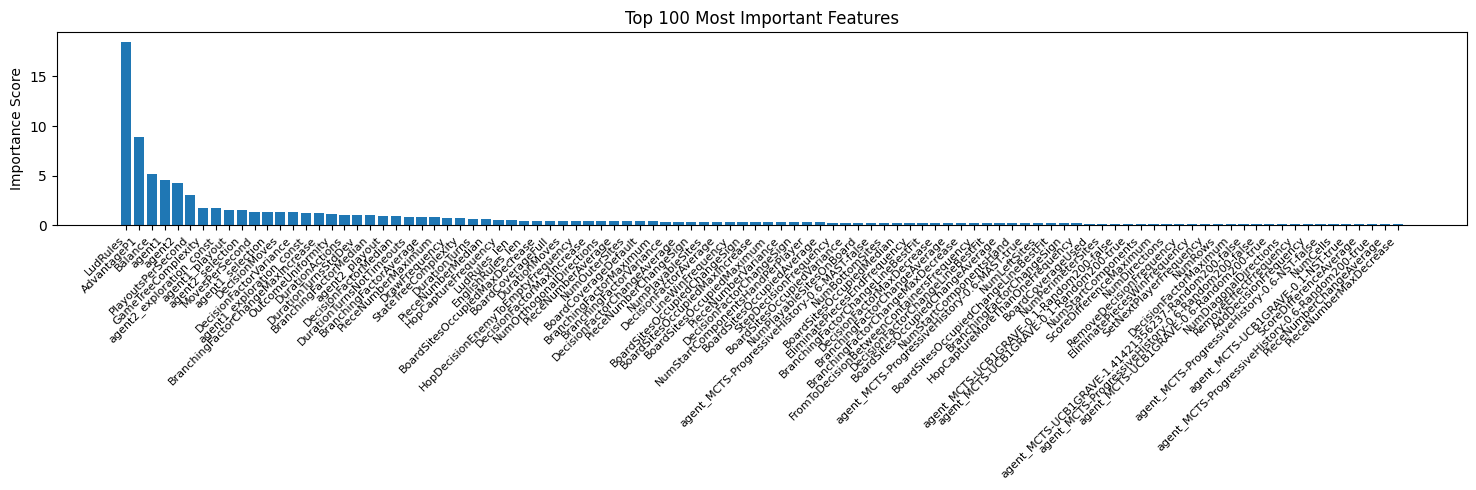

Fold 4 - RMSE: 0.4241842250574549
Fold 5


0:	learn: 0.6047347	test: 0.5847392	best: 0.5847392 (0)	total: 672ms	remaining: 33m 35s


50:	learn: 0.3922365	test: 0.4721284	best: 0.4721284 (50)	total: 33.9s	remaining: 32m 40s


100:	learn: 0.3569979	test: 0.4520769	best: 0.4520769 (100)	total: 1m 7s	remaining: 32m 24s


150:	learn: 0.3342169	test: 0.4399787	best: 0.4399787 (150)	total: 1m 41s	remaining: 31m 49s


200:	learn: 0.3190256	test: 0.4336679	best: 0.4336679 (200)	total: 2m 14s	remaining: 31m 10s


250:	learn: 0.3072780	test: 0.4306075	best: 0.4305539 (248)	total: 2m 47s	remaining: 30m 38s


300:	learn: 0.2972918	test: 0.4282926	best: 0.4282926 (300)	total: 3m 21s	remaining: 30m 6s


350:	learn: 0.2890475	test: 0.4268035	best: 0.4268035 (350)	total: 3m 54s	remaining: 29m 31s


400:	learn: 0.2812407	test: 0.4254190	best: 0.4254190 (400)	total: 4m 28s	remaining: 28m 58s


450:	learn: 0.2744384	test: 0.4236739	best: 0.4236694 (449)	total: 5m 1s	remaining: 28m 26s


500:	learn: 0.2683001	test: 0.4225527	best: 0.4225527 (500)	total: 5m 35s	remaining: 27m 53s


550:	learn: 0.2630203	test: 0.4215727	best: 0.4214793 (544)	total: 6m 9s	remaining: 27m 21s


600:	learn: 0.2585104	test: 0.4209830	best: 0.4209830 (600)	total: 6m 43s	remaining: 26m 49s


650:	learn: 0.2544059	test: 0.4201219	best: 0.4201219 (650)	total: 7m 17s	remaining: 26m 18s


700:	learn: 0.2502800	test: 0.4195597	best: 0.4195597 (700)	total: 7m 51s	remaining: 25m 46s


750:	learn: 0.2464817	test: 0.4190476	best: 0.4190476 (750)	total: 8m 25s	remaining: 25m 13s


800:	learn: 0.2430518	test: 0.4186589	best: 0.4186589 (800)	total: 8m 59s	remaining: 24m 41s


850:	learn: 0.2400099	test: 0.4183065	best: 0.4182911 (849)	total: 9m 33s	remaining: 24m 8s


900:	learn: 0.2373030	test: 0.4179503	best: 0.4179449 (896)	total: 10m 7s	remaining: 23m 35s


950:	learn: 0.2348901	test: 0.4176675	best: 0.4176675 (950)	total: 10m 41s	remaining: 23m 3s


1000:	learn: 0.2323759	test: 0.4175847	best: 0.4175299 (989)	total: 11m 16s	remaining: 22m 30s


1050:	learn: 0.2299196	test: 0.4174471	best: 0.4174426 (1036)	total: 11m 50s	remaining: 21m 56s


1100:	learn: 0.2275908	test: 0.4172347	best: 0.4172185 (1086)	total: 12m 24s	remaining: 21m 23s


1150:	learn: 0.2253818	test: 0.4169628	best: 0.4169628 (1150)	total: 12m 58s	remaining: 20m 50s


1200:	learn: 0.2233188	test: 0.4168358	best: 0.4168264 (1189)	total: 13m 32s	remaining: 20m 16s


1250:	learn: 0.2215037	test: 0.4167468	best: 0.4167340 (1241)	total: 14m 6s	remaining: 19m 43s


1300:	learn: 0.2193676	test: 0.4167194	best: 0.4166978 (1296)	total: 14m 40s	remaining: 19m 10s


1350:	learn: 0.2173220	test: 0.4164998	best: 0.4164869 (1338)	total: 15m 15s	remaining: 18m 37s


1400:	learn: 0.2155648	test: 0.4164065	best: 0.4163935 (1361)	total: 15m 49s	remaining: 18m 3s


1450:	learn: 0.2136787	test: 0.4163680	best: 0.4163651 (1449)	total: 16m 23s	remaining: 17m 29s


1500:	learn: 0.2120087	test: 0.4162432	best: 0.4162239 (1484)	total: 16m 57s	remaining: 16m 56s


1550:	learn: 0.2105327	test: 0.4161752	best: 0.4161608 (1544)	total: 17m 32s	remaining: 16m 23s


1600:	learn: 0.2090888	test: 0.4160308	best: 0.4160249 (1595)	total: 18m 7s	remaining: 15m 49s


1650:	learn: 0.2076855	test: 0.4159843	best: 0.4159647 (1627)	total: 18m 41s	remaining: 15m 16s


1700:	learn: 0.2062787	test: 0.4158837	best: 0.4158762 (1695)	total: 19m 16s	remaining: 14m 42s


1750:	learn: 0.2048001	test: 0.4157259	best: 0.4157259 (1750)	total: 19m 50s	remaining: 14m 9s


1800:	learn: 0.2032865	test: 0.4156929	best: 0.4156805 (1757)	total: 20m 24s	remaining: 13m 35s


1850:	learn: 0.2019666	test: 0.4156151	best: 0.4156112 (1847)	total: 20m 59s	remaining: 13m 1s


1900:	learn: 0.2006043	test: 0.4155849	best: 0.4155703 (1865)	total: 21m 33s	remaining: 12m 27s


1950:	learn: 0.1993215	test: 0.4155755	best: 0.4155144 (1918)	total: 22m 8s	remaining: 11m 54s


2000:	learn: 0.1978232	test: 0.4155913	best: 0.4155144 (1918)	total: 22m 42s	remaining: 11m 20s


2050:	learn: 0.1964512	test: 0.4154692	best: 0.4154559 (2047)	total: 23m 16s	remaining: 10m 46s


2100:	learn: 0.1951960	test: 0.4154070	best: 0.4153869 (2089)	total: 23m 50s	remaining: 10m 12s


2150:	learn: 0.1939352	test: 0.4153486	best: 0.4153475 (2149)	total: 24m 24s	remaining: 9m 38s


2200:	learn: 0.1925316	test: 0.4153080	best: 0.4152764 (2185)	total: 24m 59s	remaining: 9m 4s


2250:	learn: 0.1910798	test: 0.4153114	best: 0.4152764 (2185)	total: 25m 33s	remaining: 8m 30s


2300:	learn: 0.1898388	test: 0.4152523	best: 0.4152523 (2300)	total: 26m 7s	remaining: 7m 56s


2350:	learn: 0.1887391	test: 0.4151805	best: 0.4151750 (2332)	total: 26m 42s	remaining: 7m 22s


2400:	learn: 0.1875336	test: 0.4152135	best: 0.4151618 (2361)	total: 27m 16s	remaining: 6m 48s


2450:	learn: 0.1862515	test: 0.4151974	best: 0.4151618 (2361)	total: 27m 50s	remaining: 6m 14s


2500:	learn: 0.1851914	test: 0.4151440	best: 0.4151440 (2500)	total: 28m 25s	remaining: 5m 40s


2550:	learn: 0.1839877	test: 0.4150798	best: 0.4150690 (2517)	total: 29m	remaining: 5m 6s


2600:	learn: 0.1828806	test: 0.4150138	best: 0.4150138 (2600)	total: 29m 34s	remaining: 4m 32s


2650:	learn: 0.1816013	test: 0.4149193	best: 0.4149159 (2646)	total: 30m 8s	remaining: 3m 58s


2700:	learn: 0.1805504	test: 0.4149311	best: 0.4149159 (2646)	total: 30m 43s	remaining: 3m 24s


2750:	learn: 0.1795470	test: 0.4148981	best: 0.4148929 (2734)	total: 31m 17s	remaining: 2m 49s


2800:	learn: 0.1785377	test: 0.4148707	best: 0.4148655 (2784)	total: 31m 51s	remaining: 2m 15s


2850:	learn: 0.1774360	test: 0.4148560	best: 0.4148498 (2849)	total: 32m 26s	remaining: 1m 41s


2900:	learn: 0.1763806	test: 0.4148662	best: 0.4148498 (2849)	total: 33m	remaining: 1m 7s


2950:	learn: 0.1753753	test: 0.4148709	best: 0.4148426 (2923)	total: 33m 34s	remaining: 33.5s


2999:	learn: 0.1743883	test: 0.4148323	best: 0.4148323 (2999)	total: 34m 8s	remaining: 0us

bestTest = 0.4148323122
bestIteration = 2999



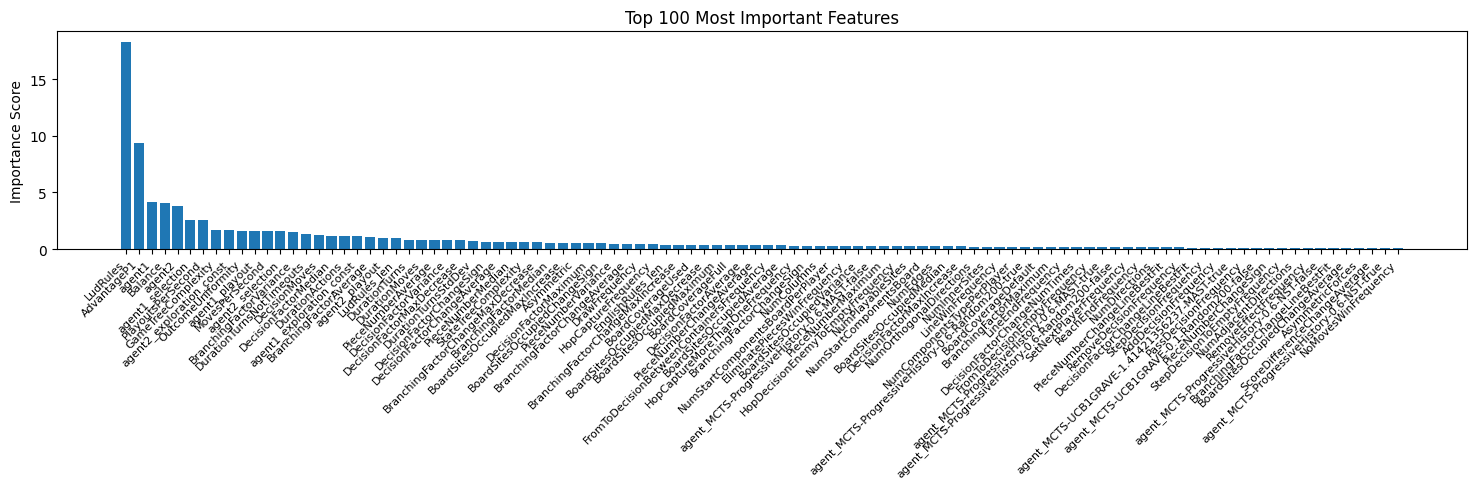

Fold 5 - RMSE: 0.4140489169265937
List of oof scores: [0.4058196036153148, 0.3955414530872851, 0.4328678847382769, 0.4241842250574549, 0.4140489169265937]
Average oof score: 0.4144924166849851


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_catboost_text_{fs_type}_cv2.parquet', index=False)

Fold 1


0:	learn: 0.6075083	test: 0.5705052	best: 0.5705052 (0)	total: 635ms	remaining: 31m 43s


50:	learn: 0.3912395	test: 0.4628666	best: 0.4628666 (50)	total: 32.7s	remaining: 31m 31s


100:	learn: 0.3542527	test: 0.4476401	best: 0.4476401 (100)	total: 1m 5s	remaining: 31m 14s


150:	learn: 0.3313175	test: 0.4396471	best: 0.4396471 (150)	total: 1m 37s	remaining: 30m 40s


200:	learn: 0.3152746	test: 0.4356618	best: 0.4356388 (199)	total: 2m 9s	remaining: 30m 6s


250:	learn: 0.3036459	test: 0.4320775	best: 0.4320775 (250)	total: 2m 42s	remaining: 29m 40s


300:	learn: 0.2940962	test: 0.4298344	best: 0.4298344 (300)	total: 3m 15s	remaining: 29m 10s


350:	learn: 0.2861202	test: 0.4281747	best: 0.4281747 (350)	total: 3m 47s	remaining: 28m 38s


400:	learn: 0.2786614	test: 0.4278571	best: 0.4275253 (391)	total: 4m 20s	remaining: 28m 5s


450:	learn: 0.2725646	test: 0.4264929	best: 0.4264892 (449)	total: 4m 52s	remaining: 27m 33s


500:	learn: 0.2668559	test: 0.4261964	best: 0.4259740 (473)	total: 5m 25s	remaining: 27m 3s


550:	learn: 0.2619500	test: 0.4255207	best: 0.4254628 (547)	total: 5m 58s	remaining: 26m 31s


600:	learn: 0.2569412	test: 0.4251291	best: 0.4251017 (599)	total: 6m 30s	remaining: 26m


650:	learn: 0.2532847	test: 0.4245883	best: 0.4245480 (644)	total: 7m 3s	remaining: 25m 29s


700:	learn: 0.2495061	test: 0.4242014	best: 0.4241877 (698)	total: 7m 37s	remaining: 24m 59s


750:	learn: 0.2461496	test: 0.4238760	best: 0.4238205 (744)	total: 8m 9s	remaining: 24m 26s


800:	learn: 0.2432278	test: 0.4237286	best: 0.4236720 (795)	total: 8m 42s	remaining: 23m 55s


850:	learn: 0.2403094	test: 0.4234686	best: 0.4234375 (837)	total: 9m 15s	remaining: 23m 23s


900:	learn: 0.2375891	test: 0.4230915	best: 0.4230915 (900)	total: 9m 48s	remaining: 22m 51s


950:	learn: 0.2350227	test: 0.4227458	best: 0.4227365 (949)	total: 10m 21s	remaining: 22m 18s


1000:	learn: 0.2323984	test: 0.4224980	best: 0.4224980 (1000)	total: 10m 54s	remaining: 21m 47s


1050:	learn: 0.2300595	test: 0.4222767	best: 0.4222679 (1047)	total: 11m 28s	remaining: 21m 16s


1100:	learn: 0.2277638	test: 0.4221435	best: 0.4221429 (1099)	total: 12m	remaining: 20m 43s


1150:	learn: 0.2255770	test: 0.4218964	best: 0.4218964 (1150)	total: 12m 34s	remaining: 20m 11s


1200:	learn: 0.2235092	test: 0.4216857	best: 0.4216857 (1200)	total: 13m 7s	remaining: 19m 40s


1250:	learn: 0.2215250	test: 0.4217171	best: 0.4216130 (1231)	total: 13m 41s	remaining: 19m 7s


1300:	learn: 0.2197490	test: 0.4215113	best: 0.4214933 (1299)	total: 14m 14s	remaining: 18m 35s


1350:	learn: 0.2178119	test: 0.4216264	best: 0.4214933 (1299)	total: 14m 47s	remaining: 18m 2s


1400:	learn: 0.2161685	test: 0.4215658	best: 0.4214933 (1299)	total: 15m 20s	remaining: 17m 30s


1450:	learn: 0.2142982	test: 0.4214594	best: 0.4214451 (1437)	total: 15m 53s	remaining: 16m 57s


1500:	learn: 0.2127304	test: 0.4213408	best: 0.4213131 (1490)	total: 16m 26s	remaining: 16m 25s


1550:	learn: 0.2111798	test: 0.4212581	best: 0.4212264 (1547)	total: 16m 59s	remaining: 15m 52s


1600:	learn: 0.2095526	test: 0.4211898	best: 0.4211691 (1586)	total: 17m 32s	remaining: 15m 19s


1650:	learn: 0.2080288	test: 0.4212198	best: 0.4211691 (1586)	total: 18m 5s	remaining: 14m 47s


1700:	learn: 0.2063053	test: 0.4211607	best: 0.4211337 (1672)	total: 18m 38s	remaining: 14m 14s


1750:	learn: 0.2049654	test: 0.4211200	best: 0.4211109 (1739)	total: 19m 11s	remaining: 13m 41s


1800:	learn: 0.2035217	test: 0.4209846	best: 0.4209846 (1800)	total: 19m 44s	remaining: 13m 8s


1850:	learn: 0.2020964	test: 0.4209073	best: 0.4208770 (1828)	total: 20m 17s	remaining: 12m 36s


1900:	learn: 0.2007024	test: 0.4208745	best: 0.4208545 (1892)	total: 20m 51s	remaining: 12m 3s


1950:	learn: 0.1993574	test: 0.4208847	best: 0.4208082 (1922)	total: 21m 24s	remaining: 11m 30s


2000:	learn: 0.1980405	test: 0.4208627	best: 0.4208082 (1922)	total: 21m 57s	remaining: 10m 57s


2050:	learn: 0.1967908	test: 0.4207948	best: 0.4207847 (2038)	total: 22m 31s	remaining: 10m 25s


2100:	learn: 0.1955415	test: 0.4208076	best: 0.4207847 (2038)	total: 23m 4s	remaining: 9m 52s


2150:	learn: 0.1943699	test: 0.4208516	best: 0.4207847 (2038)	total: 23m 37s	remaining: 9m 19s


2200:	learn: 0.1931025	test: 0.4207944	best: 0.4207847 (2038)	total: 24m 10s	remaining: 8m 46s


2250:	learn: 0.1917585	test: 0.4207486	best: 0.4207311 (2235)	total: 24m 44s	remaining: 8m 13s


2300:	learn: 0.1905510	test: 0.4208609	best: 0.4207311 (2235)	total: 25m 17s	remaining: 7m 41s


2350:	learn: 0.1894131	test: 0.4207922	best: 0.4207311 (2235)	total: 25m 50s	remaining: 7m 8s


2400:	learn: 0.1882362	test: 0.4208540	best: 0.4207311 (2235)	total: 26m 24s	remaining: 6m 35s


2450:	learn: 0.1872038	test: 0.4208438	best: 0.4207311 (2235)	total: 26m 57s	remaining: 6m 2s


2500:	learn: 0.1861312	test: 0.4207714	best: 0.4207311 (2235)	total: 27m 30s	remaining: 5m 29s


2550:	learn: 0.1850030	test: 0.4207350	best: 0.4207297 (2549)	total: 28m 3s	remaining: 4m 56s


2600:	learn: 0.1839129	test: 0.4207638	best: 0.4207297 (2549)	total: 28m 36s	remaining: 4m 23s


2650:	learn: 0.1828638	test: 0.4207355	best: 0.4207297 (2549)	total: 29m 9s	remaining: 3m 50s


2700:	learn: 0.1818516	test: 0.4207702	best: 0.4207106 (2653)	total: 29m 43s	remaining: 3m 17s


2750:	learn: 0.1807110	test: 0.4208105	best: 0.4207106 (2653)	total: 30m 16s	remaining: 2m 44s


2800:	learn: 0.1797642	test: 0.4208174	best: 0.4207106 (2653)	total: 30m 49s	remaining: 2m 11s


2850:	learn: 0.1787282	test: 0.4208300	best: 0.4207106 (2653)	total: 31m 22s	remaining: 1m 38s


2900:	learn: 0.1777510	test: 0.4208918	best: 0.4207106 (2653)	total: 31m 55s	remaining: 1m 5s


2950:	learn: 0.1767037	test: 0.4209671	best: 0.4207106 (2653)	total: 32m 28s	remaining: 32.4s


2999:	learn: 0.1757179	test: 0.4209663	best: 0.4207106 (2653)	total: 33m	remaining: 0us

bestTest = 0.4207106015
bestIteration = 2653

Shrink model to first 2654 iterations.


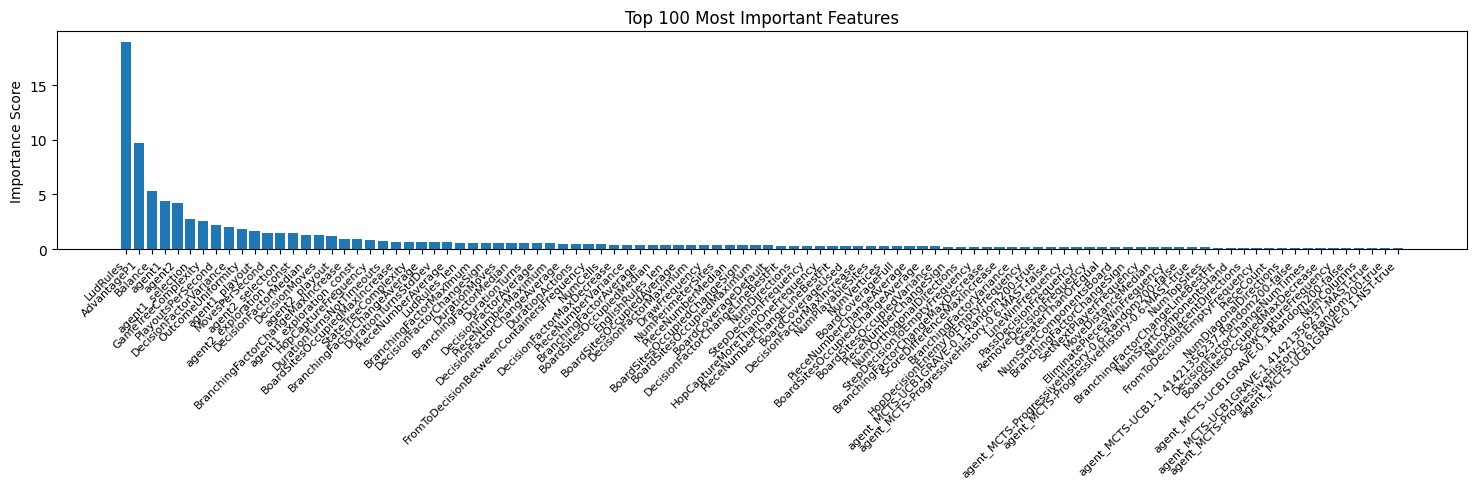

Fold 1 - RMSE: 0.42019874157445936
Fold 2


0:	learn: 0.6060454	test: 0.5683127	best: 0.5683127 (0)	total: 634ms	remaining: 31m 42s


50:	learn: 0.3925524	test: 0.4606035	best: 0.4606035 (50)	total: 34.2s	remaining: 32m 55s


100:	learn: 0.3586945	test: 0.4423635	best: 0.4423635 (100)	total: 1m 8s	remaining: 32m 44s


150:	learn: 0.3358884	test: 0.4323247	best: 0.4323247 (150)	total: 1m 42s	remaining: 32m 9s


200:	learn: 0.3190667	test: 0.4257761	best: 0.4257761 (200)	total: 2m 16s	remaining: 31m 43s


250:	learn: 0.3067032	test: 0.4216430	best: 0.4216430 (250)	total: 2m 50s	remaining: 31m 5s


300:	learn: 0.2968301	test: 0.4189866	best: 0.4189866 (300)	total: 3m 24s	remaining: 30m 34s


350:	learn: 0.2883745	test: 0.4173458	best: 0.4173078 (349)	total: 3m 58s	remaining: 30m 1s


400:	learn: 0.2815707	test: 0.4156651	best: 0.4156651 (400)	total: 4m 33s	remaining: 29m 30s


450:	learn: 0.2751784	test: 0.4146119	best: 0.4145773 (448)	total: 5m 7s	remaining: 28m 56s


500:	learn: 0.2696761	test: 0.4138911	best: 0.4138911 (500)	total: 5m 41s	remaining: 28m 22s


550:	learn: 0.2647509	test: 0.4134061	best: 0.4133945 (545)	total: 6m 15s	remaining: 27m 48s


600:	learn: 0.2604957	test: 0.4126781	best: 0.4126713 (596)	total: 6m 49s	remaining: 27m 14s


650:	learn: 0.2561590	test: 0.4117686	best: 0.4117686 (650)	total: 7m 23s	remaining: 26m 41s


700:	learn: 0.2523123	test: 0.4113027	best: 0.4112624 (698)	total: 7m 57s	remaining: 26m 7s


750:	learn: 0.2485908	test: 0.4108783	best: 0.4108404 (747)	total: 8m 32s	remaining: 25m 33s


800:	learn: 0.2454803	test: 0.4102632	best: 0.4102632 (800)	total: 9m 6s	remaining: 24m 59s


850:	learn: 0.2425292	test: 0.4098344	best: 0.4098153 (848)	total: 9m 40s	remaining: 24m 26s


900:	learn: 0.2398359	test: 0.4095010	best: 0.4095010 (900)	total: 10m 15s	remaining: 23m 52s


950:	learn: 0.2369641	test: 0.4091308	best: 0.4091308 (950)	total: 10m 49s	remaining: 23m 19s


1000:	learn: 0.2345703	test: 0.4089006	best: 0.4088670 (979)	total: 11m 23s	remaining: 22m 45s


1050:	learn: 0.2321295	test: 0.4087389	best: 0.4087055 (1045)	total: 11m 58s	remaining: 22m 11s


1100:	learn: 0.2298493	test: 0.4085602	best: 0.4085602 (1100)	total: 12m 32s	remaining: 21m 38s


1150:	learn: 0.2276252	test: 0.4084591	best: 0.4084440 (1149)	total: 13m 7s	remaining: 21m 4s


1200:	learn: 0.2253312	test: 0.4082160	best: 0.4081956 (1191)	total: 13m 42s	remaining: 20m 31s


1250:	learn: 0.2233288	test: 0.4079849	best: 0.4079849 (1250)	total: 14m 16s	remaining: 19m 57s


1300:	learn: 0.2212332	test: 0.4079297	best: 0.4078828 (1288)	total: 14m 51s	remaining: 19m 23s


1350:	learn: 0.2194428	test: 0.4076955	best: 0.4076861 (1346)	total: 15m 25s	remaining: 18m 50s


1400:	learn: 0.2176996	test: 0.4076309	best: 0.4076302 (1399)	total: 16m	remaining: 18m 16s


1450:	learn: 0.2158932	test: 0.4075524	best: 0.4075490 (1447)	total: 16m 35s	remaining: 17m 42s


1500:	learn: 0.2143042	test: 0.4074384	best: 0.4074072 (1476)	total: 17m 9s	remaining: 17m 8s


1550:	learn: 0.2127032	test: 0.4072932	best: 0.4072875 (1547)	total: 17m 44s	remaining: 16m 34s


1600:	learn: 0.2110364	test: 0.4072594	best: 0.4072305 (1585)	total: 18m 19s	remaining: 16m


1650:	learn: 0.2093981	test: 0.4071822	best: 0.4071731 (1642)	total: 18m 53s	remaining: 15m 26s


1700:	learn: 0.2079623	test: 0.4071585	best: 0.4071517 (1698)	total: 19m 28s	remaining: 14m 52s


1750:	learn: 0.2065646	test: 0.4070654	best: 0.4070627 (1746)	total: 20m 3s	remaining: 14m 18s


1800:	learn: 0.2051627	test: 0.4069758	best: 0.4069758 (1800)	total: 20m 37s	remaining: 13m 44s


1850:	learn: 0.2038022	test: 0.4069181	best: 0.4069181 (1850)	total: 21m 12s	remaining: 13m 9s


1900:	learn: 0.2023193	test: 0.4069669	best: 0.4069159 (1851)	total: 21m 46s	remaining: 12m 35s


1950:	learn: 0.2009337	test: 0.4068843	best: 0.4068804 (1949)	total: 22m 21s	remaining: 12m 1s


2000:	learn: 0.1995811	test: 0.4069095	best: 0.4068390 (1980)	total: 22m 55s	remaining: 11m 26s


2050:	learn: 0.1983024	test: 0.4068391	best: 0.4068108 (2046)	total: 23m 30s	remaining: 10m 52s


2100:	learn: 0.1969809	test: 0.4067510	best: 0.4067359 (2098)	total: 24m 5s	remaining: 10m 18s


2150:	learn: 0.1956919	test: 0.4067483	best: 0.4067274 (2136)	total: 24m 40s	remaining: 9m 44s


2200:	learn: 0.1943808	test: 0.4067175	best: 0.4067041 (2185)	total: 25m 15s	remaining: 9m 10s


2250:	learn: 0.1930777	test: 0.4066337	best: 0.4066302 (2249)	total: 25m 49s	remaining: 8m 35s


2300:	learn: 0.1918312	test: 0.4066844	best: 0.4066183 (2262)	total: 26m 24s	remaining: 8m 1s


2350:	learn: 0.1905356	test: 0.4066686	best: 0.4066183 (2262)	total: 26m 58s	remaining: 7m 26s


2400:	learn: 0.1893138	test: 0.4067222	best: 0.4066183 (2262)	total: 27m 32s	remaining: 6m 52s


2450:	learn: 0.1880988	test: 0.4066530	best: 0.4066183 (2262)	total: 28m 7s	remaining: 6m 17s


2500:	learn: 0.1869021	test: 0.4065343	best: 0.4065271 (2498)	total: 28m 41s	remaining: 5m 43s


2550:	learn: 0.1858271	test: 0.4063342	best: 0.4063342 (2550)	total: 29m 16s	remaining: 5m 9s


2600:	learn: 0.1847296	test: 0.4063649	best: 0.4063091 (2584)	total: 29m 51s	remaining: 4m 34s


2650:	learn: 0.1836133	test: 0.4063957	best: 0.4063091 (2584)	total: 30m 26s	remaining: 4m


2700:	learn: 0.1824773	test: 0.4063517	best: 0.4063091 (2584)	total: 31m	remaining: 3m 25s


2750:	learn: 0.1813578	test: 0.4063470	best: 0.4063091 (2584)	total: 31m 34s	remaining: 2m 51s


2800:	learn: 0.1802877	test: 0.4063429	best: 0.4063091 (2584)	total: 32m 9s	remaining: 2m 17s


2850:	learn: 0.1791801	test: 0.4064030	best: 0.4063091 (2584)	total: 32m 44s	remaining: 1m 42s


2900:	learn: 0.1781530	test: 0.4063954	best: 0.4063091 (2584)	total: 33m 18s	remaining: 1m 8s


2950:	learn: 0.1770624	test: 0.4063975	best: 0.4063091 (2584)	total: 33m 53s	remaining: 33.8s


2999:	learn: 0.1760549	test: 0.4064280	best: 0.4063091 (2584)	total: 34m 27s	remaining: 0us

bestTest = 0.4063091042
bestIteration = 2584

Shrink model to first 2585 iterations.


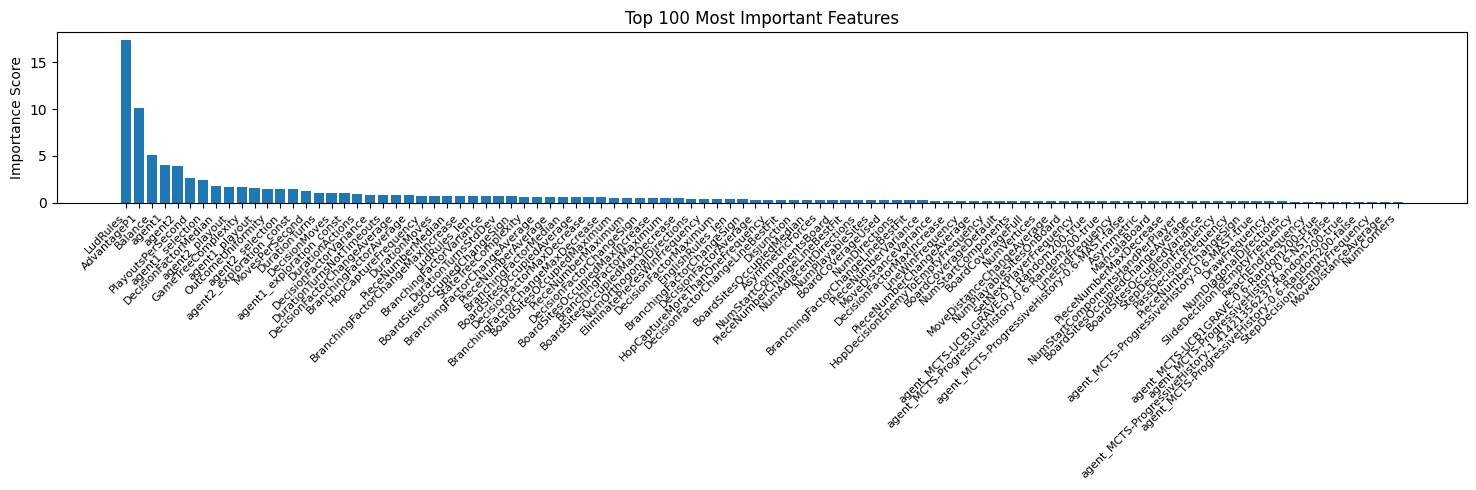

Fold 2 - RMSE: 0.40587643856954225
Fold 3


0:	learn: 0.6098535	test: 0.5765319	best: 0.5765319 (0)	total: 655ms	remaining: 32m 43s


50:	learn: 0.3898632	test: 0.4635803	best: 0.4635803 (50)	total: 34.1s	remaining: 32m 51s


100:	learn: 0.3553622	test: 0.4478843	best: 0.4478843 (100)	total: 1m 7s	remaining: 32m 20s


150:	learn: 0.3325110	test: 0.4384258	best: 0.4384258 (150)	total: 1m 40s	remaining: 31m 37s


200:	learn: 0.3164578	test: 0.4340122	best: 0.4340122 (200)	total: 2m 13s	remaining: 30m 56s


250:	learn: 0.3047352	test: 0.4298447	best: 0.4297891 (246)	total: 2m 46s	remaining: 30m 21s


300:	learn: 0.2953219	test: 0.4274404	best: 0.4274404 (300)	total: 3m 19s	remaining: 29m 48s


350:	learn: 0.2876252	test: 0.4262160	best: 0.4262160 (350)	total: 3m 53s	remaining: 29m 18s


400:	learn: 0.2801059	test: 0.4245143	best: 0.4245143 (400)	total: 4m 26s	remaining: 28m 44s


450:	learn: 0.2739053	test: 0.4233260	best: 0.4233260 (450)	total: 4m 59s	remaining: 28m 12s


500:	learn: 0.2683470	test: 0.4223601	best: 0.4223461 (499)	total: 5m 32s	remaining: 27m 40s


550:	learn: 0.2630448	test: 0.4218838	best: 0.4218358 (548)	total: 6m 6s	remaining: 27m 7s


600:	learn: 0.2585863	test: 0.4210549	best: 0.4210549 (600)	total: 6m 39s	remaining: 26m 35s


650:	learn: 0.2542275	test: 0.4206709	best: 0.4206424 (649)	total: 7m 13s	remaining: 26m 3s


700:	learn: 0.2503344	test: 0.4204566	best: 0.4204192 (699)	total: 7m 46s	remaining: 25m 29s


750:	learn: 0.2469065	test: 0.4203931	best: 0.4203743 (748)	total: 8m 20s	remaining: 24m 58s


800:	learn: 0.2436719	test: 0.4201456	best: 0.4201438 (799)	total: 8m 54s	remaining: 24m 26s


850:	learn: 0.2407770	test: 0.4197433	best: 0.4197433 (850)	total: 9m 27s	remaining: 23m 53s


900:	learn: 0.2377512	test: 0.4194092	best: 0.4194010 (898)	total: 10m 1s	remaining: 23m 20s


950:	learn: 0.2351434	test: 0.4192126	best: 0.4191881 (933)	total: 10m 34s	remaining: 22m 47s


1000:	learn: 0.2326315	test: 0.4188197	best: 0.4188197 (1000)	total: 11m 8s	remaining: 22m 14s


1050:	learn: 0.2300899	test: 0.4186285	best: 0.4186161 (1045)	total: 11m 41s	remaining: 21m 41s


1100:	learn: 0.2278423	test: 0.4184613	best: 0.4184613 (1100)	total: 12m 15s	remaining: 21m 8s


1150:	learn: 0.2256804	test: 0.4181279	best: 0.4181279 (1150)	total: 12m 49s	remaining: 20m 35s


1200:	learn: 0.2237086	test: 0.4181196	best: 0.4180713 (1167)	total: 13m 23s	remaining: 20m 3s


1250:	learn: 0.2215334	test: 0.4180645	best: 0.4180133 (1216)	total: 13m 57s	remaining: 19m 30s


1300:	learn: 0.2196404	test: 0.4178392	best: 0.4178392 (1300)	total: 14m 31s	remaining: 18m 57s


1350:	learn: 0.2176313	test: 0.4177117	best: 0.4177100 (1349)	total: 15m 5s	remaining: 18m 24s


1400:	learn: 0.2157206	test: 0.4175770	best: 0.4175316 (1388)	total: 15m 38s	remaining: 17m 51s


1450:	learn: 0.2138210	test: 0.4174803	best: 0.4174654 (1448)	total: 16m 12s	remaining: 17m 18s


1500:	learn: 0.2120031	test: 0.4173593	best: 0.4173593 (1500)	total: 16m 46s	remaining: 16m 45s


1550:	learn: 0.2101873	test: 0.4171714	best: 0.4171714 (1550)	total: 17m 20s	remaining: 16m 12s


1600:	learn: 0.2084416	test: 0.4170583	best: 0.4170466 (1598)	total: 17m 54s	remaining: 15m 39s


1650:	learn: 0.2068317	test: 0.4169824	best: 0.4169678 (1644)	total: 18m 28s	remaining: 15m 5s


1700:	learn: 0.2051409	test: 0.4169177	best: 0.4169045 (1698)	total: 19m 2s	remaining: 14m 32s


1750:	learn: 0.2035509	test: 0.4169107	best: 0.4168760 (1716)	total: 19m 36s	remaining: 13m 59s


1800:	learn: 0.2019219	test: 0.4167970	best: 0.4167970 (1800)	total: 20m 10s	remaining: 13m 26s


1850:	learn: 0.2004531	test: 0.4167737	best: 0.4167643 (1844)	total: 20m 44s	remaining: 12m 52s


1900:	learn: 0.1989537	test: 0.4165783	best: 0.4165747 (1896)	total: 21m 18s	remaining: 12m 19s


1950:	learn: 0.1976432	test: 0.4166101	best: 0.4165540 (1919)	total: 21m 52s	remaining: 11m 45s


2000:	learn: 0.1962776	test: 0.4165364	best: 0.4165216 (1998)	total: 22m 26s	remaining: 11m 12s


2050:	learn: 0.1948737	test: 0.4164953	best: 0.4164839 (2047)	total: 22m 59s	remaining: 10m 38s


2100:	learn: 0.1935923	test: 0.4165007	best: 0.4164761 (2067)	total: 23m 33s	remaining: 10m 4s


2150:	learn: 0.1922955	test: 0.4164902	best: 0.4164761 (2067)	total: 24m 7s	remaining: 9m 31s


2200:	learn: 0.1910493	test: 0.4164952	best: 0.4164521 (2176)	total: 24m 41s	remaining: 8m 57s


2250:	learn: 0.1899033	test: 0.4164643	best: 0.4164521 (2176)	total: 25m 15s	remaining: 8m 24s


2300:	learn: 0.1885734	test: 0.4164856	best: 0.4164521 (2176)	total: 25m 49s	remaining: 7m 50s


2350:	learn: 0.1872410	test: 0.4164802	best: 0.4164521 (2176)	total: 26m 23s	remaining: 7m 17s


2400:	learn: 0.1860476	test: 0.4164781	best: 0.4164430 (2377)	total: 26m 57s	remaining: 6m 43s


2450:	learn: 0.1847376	test: 0.4164620	best: 0.4164430 (2377)	total: 27m 31s	remaining: 6m 9s


2500:	learn: 0.1835588	test: 0.4164575	best: 0.4164420 (2452)	total: 28m 4s	remaining: 5m 36s


2550:	learn: 0.1824904	test: 0.4164929	best: 0.4164420 (2452)	total: 28m 38s	remaining: 5m 2s


2600:	learn: 0.1814151	test: 0.4165197	best: 0.4164420 (2452)	total: 29m 12s	remaining: 4m 28s


2650:	learn: 0.1803102	test: 0.4164658	best: 0.4164420 (2452)	total: 29m 46s	remaining: 3m 55s


2700:	learn: 0.1791415	test: 0.4164547	best: 0.4164418 (2686)	total: 30m 19s	remaining: 3m 21s


2750:	learn: 0.1780324	test: 0.4163557	best: 0.4163557 (2750)	total: 30m 53s	remaining: 2m 47s


2800:	learn: 0.1769263	test: 0.4163516	best: 0.4163054 (2782)	total: 31m 27s	remaining: 2m 14s


2850:	learn: 0.1758960	test: 0.4163537	best: 0.4163054 (2782)	total: 32m 1s	remaining: 1m 40s


2900:	learn: 0.1748815	test: 0.4162813	best: 0.4162622 (2894)	total: 32m 36s	remaining: 1m 6s


2950:	learn: 0.1737933	test: 0.4162803	best: 0.4162622 (2894)	total: 33m 9s	remaining: 33s


2999:	learn: 0.1727917	test: 0.4162754	best: 0.4162306 (2974)	total: 33m 42s	remaining: 0us

bestTest = 0.4162306013
bestIteration = 2974

Shrink model to first 2975 iterations.


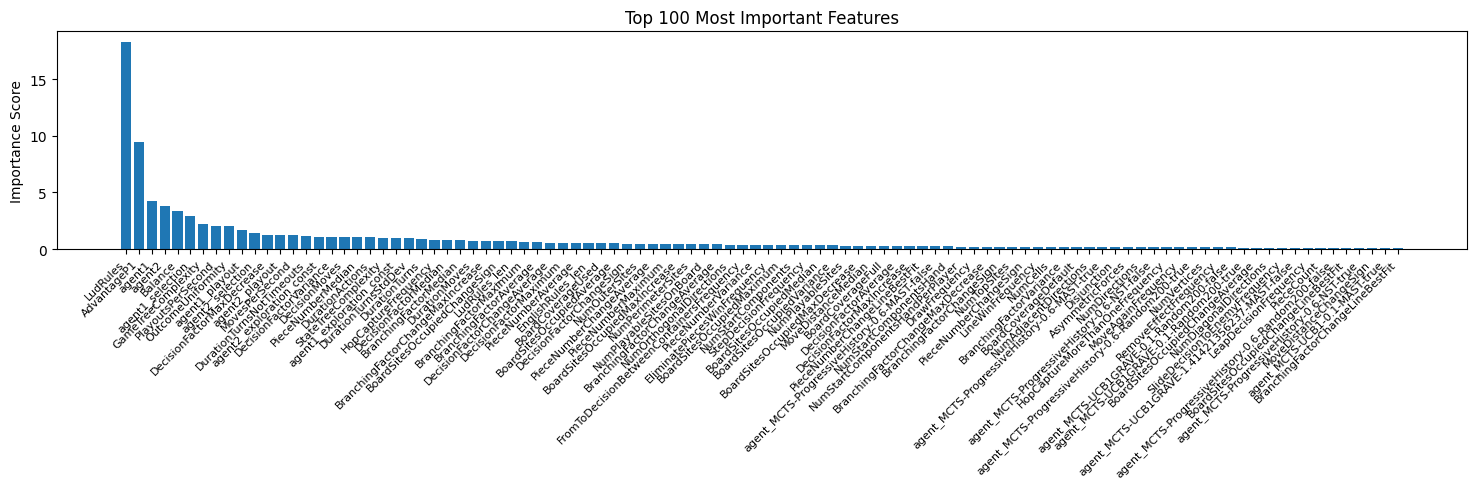

Fold 3 - RMSE: 0.4157513811959377
Fold 4


0:	learn: 0.6082827	test: 0.5673919	best: 0.5673919 (0)	total: 657ms	remaining: 32m 49s


50:	learn: 0.3933414	test: 0.4642214	best: 0.4642214 (50)	total: 34.9s	remaining: 33m 35s


100:	learn: 0.3564445	test: 0.4459941	best: 0.4459941 (100)	total: 1m 8s	remaining: 32m 36s


150:	learn: 0.3348838	test: 0.4371089	best: 0.4370130 (149)	total: 1m 40s	remaining: 31m 28s


200:	learn: 0.3182501	test: 0.4319793	best: 0.4319793 (200)	total: 2m 12s	remaining: 30m 39s


250:	learn: 0.3066303	test: 0.4296252	best: 0.4296252 (250)	total: 2m 44s	remaining: 30m 1s


300:	learn: 0.2969796	test: 0.4280183	best: 0.4279979 (295)	total: 3m 16s	remaining: 29m 21s


350:	learn: 0.2884248	test: 0.4261078	best: 0.4261078 (350)	total: 3m 48s	remaining: 28m 47s


400:	learn: 0.2806246	test: 0.4247271	best: 0.4247271 (400)	total: 4m 21s	remaining: 28m 12s


450:	learn: 0.2743753	test: 0.4229246	best: 0.4229246 (450)	total: 4m 53s	remaining: 27m 40s


500:	learn: 0.2685840	test: 0.4221111	best: 0.4221111 (500)	total: 5m 26s	remaining: 27m 8s


550:	learn: 0.2638859	test: 0.4216633	best: 0.4216456 (542)	total: 5m 59s	remaining: 26m 38s


600:	learn: 0.2593958	test: 0.4211670	best: 0.4211070 (591)	total: 6m 32s	remaining: 26m 7s


650:	learn: 0.2554574	test: 0.4205339	best: 0.4205339 (650)	total: 7m 5s	remaining: 25m 36s


700:	learn: 0.2515931	test: 0.4199759	best: 0.4199397 (699)	total: 7m 38s	remaining: 25m 3s


750:	learn: 0.2479022	test: 0.4193885	best: 0.4193885 (750)	total: 8m 11s	remaining: 24m 31s


800:	learn: 0.2445286	test: 0.4192006	best: 0.4191455 (798)	total: 8m 43s	remaining: 23m 57s


850:	learn: 0.2414078	test: 0.4186547	best: 0.4186547 (850)	total: 9m 16s	remaining: 23m 25s


900:	learn: 0.2384139	test: 0.4184802	best: 0.4184802 (900)	total: 9m 49s	remaining: 22m 53s


950:	learn: 0.2356718	test: 0.4179864	best: 0.4179864 (950)	total: 10m 23s	remaining: 22m 24s


1000:	learn: 0.2334285	test: 0.4178138	best: 0.4178138 (1000)	total: 10m 57s	remaining: 21m 53s


1050:	learn: 0.2309366	test: 0.4177262	best: 0.4176677 (1033)	total: 11m 32s	remaining: 21m 23s


1100:	learn: 0.2287506	test: 0.4177380	best: 0.4176677 (1033)	total: 12m 5s	remaining: 20m 51s


1150:	learn: 0.2263929	test: 0.4176087	best: 0.4176087 (1150)	total: 12m 38s	remaining: 20m 18s


1200:	learn: 0.2242355	test: 0.4174927	best: 0.4174861 (1185)	total: 13m 12s	remaining: 19m 46s


1250:	learn: 0.2223838	test: 0.4173731	best: 0.4173451 (1226)	total: 13m 46s	remaining: 19m 15s


1300:	learn: 0.2204254	test: 0.4173612	best: 0.4172993 (1282)	total: 14m 20s	remaining: 18m 43s


1350:	learn: 0.2184184	test: 0.4172463	best: 0.4172463 (1350)	total: 14m 53s	remaining: 18m 10s


1400:	learn: 0.2163872	test: 0.4171403	best: 0.4171152 (1390)	total: 15m 28s	remaining: 17m 39s


1450:	learn: 0.2146564	test: 0.4170785	best: 0.4170785 (1450)	total: 16m 2s	remaining: 17m 7s


1500:	learn: 0.2128886	test: 0.4169724	best: 0.4169662 (1498)	total: 16m 37s	remaining: 16m 36s


1550:	learn: 0.2113151	test: 0.4169838	best: 0.4169640 (1502)	total: 17m 11s	remaining: 16m 3s


1600:	learn: 0.2097515	test: 0.4170000	best: 0.4169640 (1502)	total: 17m 46s	remaining: 15m 31s


1650:	learn: 0.2080002	test: 0.4168820	best: 0.4168731 (1648)	total: 18m 19s	remaining: 14m 58s


1700:	learn: 0.2063990	test: 0.4168296	best: 0.4168126 (1693)	total: 18m 52s	remaining: 14m 24s


1750:	learn: 0.2049588	test: 0.4167791	best: 0.4167687 (1749)	total: 19m 25s	remaining: 13m 51s


1800:	learn: 0.2033743	test: 0.4167391	best: 0.4167218 (1779)	total: 19m 59s	remaining: 13m 18s


1850:	learn: 0.2019193	test: 0.4167015	best: 0.4166933 (1834)	total: 20m 32s	remaining: 12m 45s


1900:	learn: 0.2002467	test: 0.4166087	best: 0.4166085 (1898)	total: 21m 6s	remaining: 12m 12s


1950:	learn: 0.1989608	test: 0.4164441	best: 0.4164441 (1950)	total: 21m 39s	remaining: 11m 38s


2000:	learn: 0.1976251	test: 0.4164797	best: 0.4164441 (1950)	total: 22m 13s	remaining: 11m 5s


2050:	learn: 0.1963586	test: 0.4164774	best: 0.4164441 (1950)	total: 22m 50s	remaining: 10m 34s


2100:	learn: 0.1950914	test: 0.4164117	best: 0.4164063 (2087)	total: 23m 25s	remaining: 10m 1s


2150:	learn: 0.1938191	test: 0.4163932	best: 0.4163827 (2141)	total: 24m	remaining: 9m 28s


2200:	learn: 0.1925070	test: 0.4164111	best: 0.4163827 (2141)	total: 24m 34s	remaining: 8m 55s


2250:	learn: 0.1912875	test: 0.4164249	best: 0.4163827 (2141)	total: 25m 8s	remaining: 8m 22s


2300:	learn: 0.1900745	test: 0.4164568	best: 0.4163827 (2141)	total: 25m 42s	remaining: 7m 48s


2350:	learn: 0.1886934	test: 0.4164059	best: 0.4163696 (2336)	total: 26m 16s	remaining: 7m 15s


2400:	learn: 0.1875287	test: 0.4163138	best: 0.4163070 (2397)	total: 26m 50s	remaining: 6m 41s


2450:	learn: 0.1863412	test: 0.4162454	best: 0.4162454 (2450)	total: 27m 25s	remaining: 6m 8s


2500:	learn: 0.1852387	test: 0.4162258	best: 0.4162231 (2481)	total: 28m	remaining: 5m 35s


2550:	learn: 0.1840889	test: 0.4162081	best: 0.4161990 (2537)	total: 28m 33s	remaining: 5m 1s


2600:	learn: 0.1829211	test: 0.4161660	best: 0.4161629 (2595)	total: 29m 7s	remaining: 4m 28s


2650:	learn: 0.1818359	test: 0.4160508	best: 0.4160508 (2650)	total: 29m 41s	remaining: 3m 54s


2700:	learn: 0.1807585	test: 0.4160720	best: 0.4160419 (2653)	total: 30m 14s	remaining: 3m 20s


2750:	learn: 0.1795958	test: 0.4159152	best: 0.4159119 (2748)	total: 30m 47s	remaining: 2m 47s


2800:	learn: 0.1785359	test: 0.4158149	best: 0.4158141 (2798)	total: 31m 21s	remaining: 2m 13s


2850:	learn: 0.1775486	test: 0.4158194	best: 0.4158057 (2823)	total: 31m 55s	remaining: 1m 40s


2900:	learn: 0.1765929	test: 0.4157939	best: 0.4157657 (2867)	total: 32m 31s	remaining: 1m 6s


2950:	learn: 0.1755878	test: 0.4158154	best: 0.4157657 (2867)	total: 33m 5s	remaining: 33s


2999:	learn: 0.1745895	test: 0.4158008	best: 0.4157657 (2867)	total: 33m 39s	remaining: 0us

bestTest = 0.4157656625
bestIteration = 2867

Shrink model to first 2868 iterations.


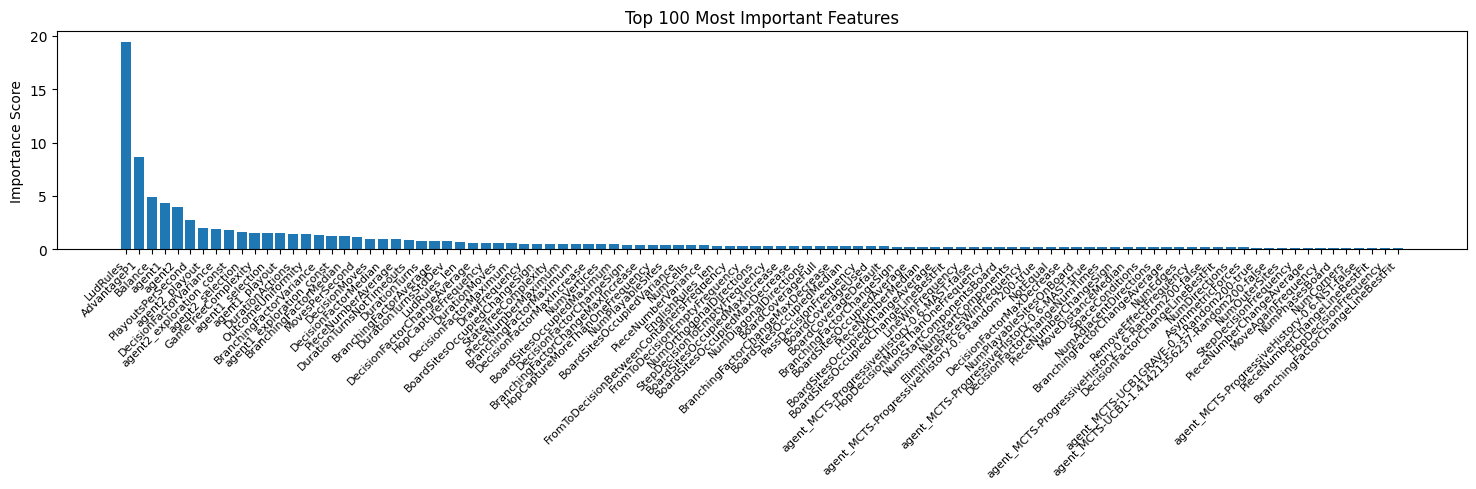

Fold 4 - RMSE: 0.41522169614106774
Fold 5


0:	learn: 0.6038199	test: 0.5788686	best: 0.5788686 (0)	total: 640ms	remaining: 32m


50:	learn: 0.3914621	test: 0.4707673	best: 0.4707673 (50)	total: 36s	remaining: 34m 41s


100:	learn: 0.3557648	test: 0.4526190	best: 0.4526190 (100)	total: 1m 10s	remaining: 33m 53s


150:	learn: 0.3322349	test: 0.4422007	best: 0.4422007 (150)	total: 1m 46s	remaining: 33m 31s


200:	learn: 0.3164138	test: 0.4361972	best: 0.4361972 (200)	total: 2m 20s	remaining: 32m 35s


250:	learn: 0.3045901	test: 0.4328311	best: 0.4327601 (249)	total: 2m 55s	remaining: 31m 57s


300:	learn: 0.2955979	test: 0.4302812	best: 0.4302314 (297)	total: 3m 30s	remaining: 31m 26s


350:	learn: 0.2873819	test: 0.4288755	best: 0.4288755 (350)	total: 4m 4s	remaining: 30m 44s


400:	learn: 0.2805278	test: 0.4276044	best: 0.4276044 (400)	total: 4m 39s	remaining: 30m 12s


450:	learn: 0.2740716	test: 0.4266651	best: 0.4265678 (443)	total: 5m 14s	remaining: 29m 36s


500:	learn: 0.2681963	test: 0.4253802	best: 0.4253802 (500)	total: 5m 50s	remaining: 29m 6s


550:	learn: 0.2633258	test: 0.4247093	best: 0.4247093 (550)	total: 6m 25s	remaining: 28m 31s


600:	learn: 0.2589073	test: 0.4240510	best: 0.4240374 (596)	total: 7m	remaining: 28m


650:	learn: 0.2548767	test: 0.4237639	best: 0.4237378 (648)	total: 7m 35s	remaining: 27m 23s


700:	learn: 0.2510199	test: 0.4235534	best: 0.4235534 (700)	total: 8m 10s	remaining: 26m 47s


750:	learn: 0.2477523	test: 0.4232548	best: 0.4232548 (750)	total: 8m 44s	remaining: 26m 10s


800:	learn: 0.2445830	test: 0.4229766	best: 0.4229625 (785)	total: 9m 18s	remaining: 25m 34s


850:	learn: 0.2413605	test: 0.4225767	best: 0.4225450 (846)	total: 9m 53s	remaining: 24m 58s


900:	learn: 0.2388247	test: 0.4223917	best: 0.4223917 (900)	total: 10m 28s	remaining: 24m 24s


950:	learn: 0.2361938	test: 0.4220078	best: 0.4219968 (949)	total: 11m 2s	remaining: 23m 48s


1000:	learn: 0.2336069	test: 0.4219367	best: 0.4219167 (997)	total: 11m 37s	remaining: 23m 12s


1050:	learn: 0.2312675	test: 0.4218217	best: 0.4218159 (1048)	total: 12m 11s	remaining: 22m 37s


1100:	learn: 0.2289882	test: 0.4217301	best: 0.4217263 (1099)	total: 12m 46s	remaining: 22m 1s


1150:	learn: 0.2264772	test: 0.4215329	best: 0.4214962 (1144)	total: 13m 20s	remaining: 21m 26s


1200:	learn: 0.2244499	test: 0.4214461	best: 0.4214313 (1193)	total: 13m 55s	remaining: 20m 50s


1250:	learn: 0.2222888	test: 0.4214584	best: 0.4213604 (1244)	total: 14m 30s	remaining: 20m 16s


1300:	learn: 0.2204192	test: 0.4213025	best: 0.4212792 (1299)	total: 15m 5s	remaining: 19m 42s


1350:	learn: 0.2184222	test: 0.4210282	best: 0.4210207 (1348)	total: 15m 40s	remaining: 19m 7s


1400:	learn: 0.2166041	test: 0.4209154	best: 0.4208887 (1389)	total: 16m 15s	remaining: 18m 33s


1450:	learn: 0.2149641	test: 0.4208403	best: 0.4208335 (1446)	total: 16m 50s	remaining: 17m 58s


1500:	learn: 0.2133077	test: 0.4207461	best: 0.4207270 (1482)	total: 17m 25s	remaining: 17m 24s


1550:	learn: 0.2116586	test: 0.4207217	best: 0.4206706 (1517)	total: 18m	remaining: 16m 49s


1600:	learn: 0.2100381	test: 0.4206977	best: 0.4206706 (1517)	total: 18m 34s	remaining: 16m 14s


1650:	learn: 0.2083528	test: 0.4206605	best: 0.4206521 (1648)	total: 19m 9s	remaining: 15m 39s


1700:	learn: 0.2068867	test: 0.4206128	best: 0.4205861 (1693)	total: 19m 45s	remaining: 15m 5s


1750:	learn: 0.2052870	test: 0.4205513	best: 0.4205319 (1748)	total: 20m 21s	remaining: 14m 31s


1800:	learn: 0.2036883	test: 0.4205031	best: 0.4205005 (1796)	total: 20m 57s	remaining: 13m 57s


1850:	learn: 0.2021333	test: 0.4205220	best: 0.4205005 (1796)	total: 21m 32s	remaining: 13m 22s


1900:	learn: 0.2007351	test: 0.4203783	best: 0.4203643 (1880)	total: 22m 8s	remaining: 12m 48s


1950:	learn: 0.1994145	test: 0.4203251	best: 0.4203225 (1929)	total: 22m 44s	remaining: 12m 13s


2000:	learn: 0.1979891	test: 0.4203772	best: 0.4202868 (1962)	total: 23m 19s	remaining: 11m 38s


2050:	learn: 0.1965313	test: 0.4203496	best: 0.4202868 (1962)	total: 23m 56s	remaining: 11m 4s


2100:	learn: 0.1951540	test: 0.4203442	best: 0.4202868 (1962)	total: 24m 32s	remaining: 10m 29s


2150:	learn: 0.1938937	test: 0.4202866	best: 0.4202714 (2145)	total: 25m 8s	remaining: 9m 55s


2200:	learn: 0.1926045	test: 0.4202197	best: 0.4202167 (2197)	total: 25m 43s	remaining: 9m 20s


2250:	learn: 0.1913764	test: 0.4201576	best: 0.4201444 (2234)	total: 26m 19s	remaining: 8m 45s


2300:	learn: 0.1900491	test: 0.4200528	best: 0.4200528 (2300)	total: 26m 55s	remaining: 8m 10s


2350:	learn: 0.1889438	test: 0.4200416	best: 0.4200416 (2350)	total: 27m 32s	remaining: 7m 36s


2400:	learn: 0.1878052	test: 0.4200486	best: 0.4200234 (2366)	total: 28m 8s	remaining: 7m 1s


2450:	learn: 0.1866206	test: 0.4200832	best: 0.4200234 (2366)	total: 28m 44s	remaining: 6m 26s


2500:	learn: 0.1854231	test: 0.4200597	best: 0.4200234 (2366)	total: 29m 19s	remaining: 5m 51s


2550:	learn: 0.1842699	test: 0.4200330	best: 0.4200171 (2543)	total: 29m 54s	remaining: 5m 15s


2600:	learn: 0.1831958	test: 0.4200558	best: 0.4200171 (2543)	total: 30m 29s	remaining: 4m 40s


2650:	learn: 0.1821281	test: 0.4200839	best: 0.4200171 (2543)	total: 31m 3s	remaining: 4m 5s


2700:	learn: 0.1810679	test: 0.4200639	best: 0.4200171 (2543)	total: 31m 39s	remaining: 3m 30s


2750:	learn: 0.1798472	test: 0.4200564	best: 0.4200171 (2543)	total: 32m 15s	remaining: 2m 55s


2800:	learn: 0.1788822	test: 0.4200833	best: 0.4200171 (2543)	total: 32m 51s	remaining: 2m 20s


2850:	learn: 0.1778881	test: 0.4200515	best: 0.4200171 (2543)	total: 33m 26s	remaining: 1m 44s


2900:	learn: 0.1767921	test: 0.4200116	best: 0.4200116 (2900)	total: 34m 1s	remaining: 1m 9s


2950:	learn: 0.1758243	test: 0.4200564	best: 0.4200095 (2906)	total: 34m 37s	remaining: 34.5s


2999:	learn: 0.1747854	test: 0.4200679	best: 0.4200095 (2906)	total: 35m 12s	remaining: 0us

bestTest = 0.42000955
bestIteration = 2906

Shrink model to first 2907 iterations.


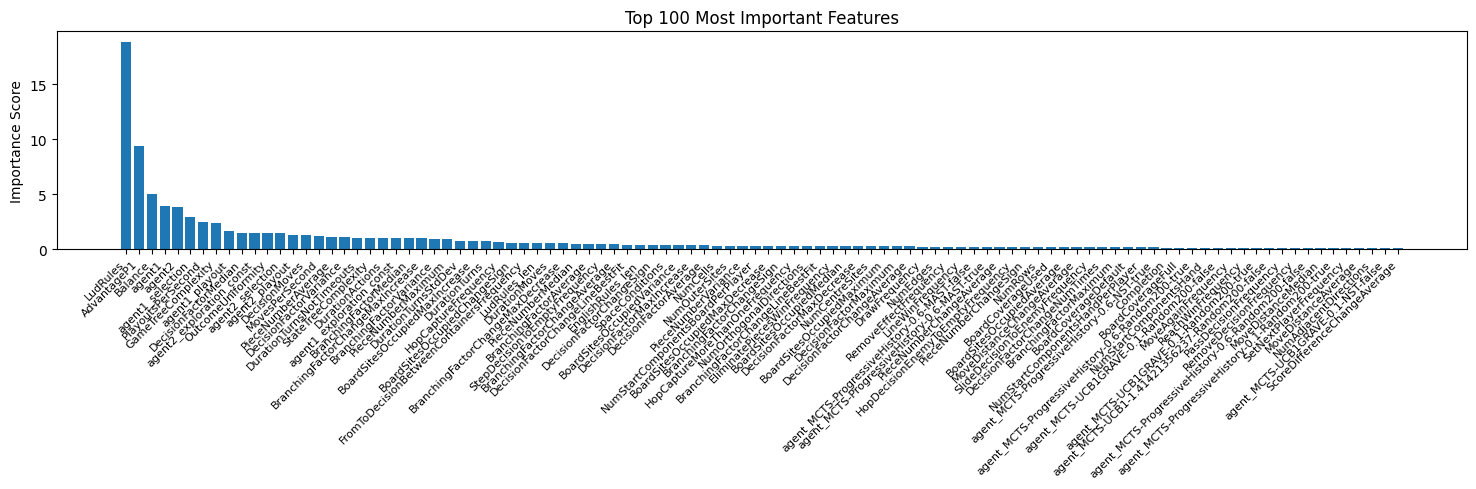

Fold 5 - RMSE: 0.41945646001347686
List of oof scores: [0.42019874157445936, 0.40587643856954225, 0.4157513811959377, 0.41522169614106774, 0.41945646001347686]
Average oof score: 0.41530094349889674


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_catboost_text_{fs_type}_cv3.parquet', index=False)

In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")


CV1 OOF Scores:
Score: 0.4206
Score: 0.4284
Score: 0.4215
Score: 0.4264
Score: 0.3946
Average CV1 Score: 0.4183

CV2 OOF Scores:
Score: 0.4058
Score: 0.3955
Score: 0.4329
Score: 0.4242
Score: 0.4140
Average CV2 Score: 0.4145

CV3 OOF Scores:
Score: 0.4202
Score: 0.4059
Score: 0.4158
Score: 0.4152
Score: 0.4195
Average CV3 Score: 0.4153


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
# trained_models = trained_models1

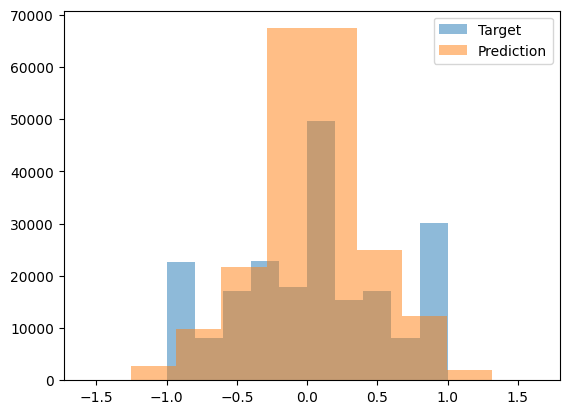

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler,
        include_position_features=True,
        include_text_features=True,
    )

    # Prepare data columns
    features = numerical_cols + categorical_cols
    pool_kwargs = {
        'data': test_processed[features],
        'cat_features': categorical_cols,
    }
    
    # Include text columns if they are not None
    if text_cols is not None:
        features += text_cols
        pool_kwargs['data'] = test_processed[features]
        pool_kwargs['text_features'] = text_cols

    # Create CatBoost Pool for test data
    test_pool = cb.Pool(**pool_kwargs)

    # Average predictions from all models
    predictions = np.mean([
        model.predict(test_pool)
        for model in trained_models
    ], axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
# sanity check
df_test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(df_test, sample_sub)

shape: (3, 2)
┌────────┬────────────────┐
│ Id     ┆ utility_agent1 │
│ ---    ┆ ---            │
│ i64    ┆ f64            │
╞════════╪════════════════╡
│ 233234 ┆ 0.154499       │
│ 233235 ┆ -0.18696       │
│ 233236 ┆ 0.015267       │
└────────┴────────────────┘

In [20]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [21]:
# Save all artifacts needed for prediction
catboost_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'text_cols': text_cols,
    'encoder': encoder, 
    'scaler': scaler
}
with open(f'./catboost_text_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(catboost_predict, f)

***